<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project_SingleCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models - Single Cell Analysis

# Notebook setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install harmonypy
%pip install symphonypy
%pip install pydeseq2
%pip install decoupler
%pip install gseapy
%pip install marsilea
%pip install adjustText
%pip install omnipath

In [ ]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import numpy as np
import pandas as pd
import symphonypy as sp
import decoupler as dc
from scipy.stats import median_abs_deviation
import gc
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from gseapy.scipalette import SciPalette

# Kim d53 samples - Data read-in

**Read in the scRNA-seq data for Kim et al dataset day 53 untreated sample and day 53 acute fentanyl treatment sample, add metadata and prepend cell barcodes with unique identifiers, and save each sample as a separate `.h5ad.gz` file. Then merge the datasets and save the merged dataset as a `h5ad.gz` file as well.**

The original sample IDs are KH001 for the day 53 untreated sample and KH002 for the day 53 acute fentanyl treatment sample. Each sample has its own folder containing 3 compressed (`.gz`) files, which are the 10X Genomics CellRanger output files:

*   `matrix.mtx.gz` is a count matrix where rows are single cells, columns are genes, and each cell is the read count of that gene in that cell
*   `barcodes.tsv.gz` contains the cell barcodes (each cell is labeled with a unique barcode, which is used as an identifier)
*   `features.tsv.gz` contains the gene names

For each of the 2 samples, we will first use `scanpy.read_10x_mtx()` to read the 3 files into a single `AnnData` object that contains the cell-by-gene matrix and associated metadata (`obs` = barcodes, `var` = features). We will add columns to the `obs` attribute, `Sample` indicating the sample name and `condition` indicating the treatment group of the sample (untreated or fentanyl). In preparation for merging these samples into one `AnnData` object later, we will prepend the cell barcodes with a sample description, "d53_ut" for untreated samples and "d53_fty" for treated samples. Then we will save each sample `AnnData` object as a compressed `.h5ad.gz` file for later use.

In [ ]:
sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH001_Day53_Untreated"
adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
adata1.obs["Sample"] = "kim_day53_untreated"
adata1.obs["condition"] = "d53_untreated"
adata1.obs.index = [f"d53_ut_{barcode}" for barcode in adata1.obs.index]
adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ut.h5ad.gz", compression="gzip")

sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH002_Day53_FTY_Acute"
adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
adata2.obs["Sample"] = "kim_d53_fty_acute"
adata2.obs["condition"] = "d53_fty_acute"
adata2.obs.index = [f"d53_fty_{barcode}" for barcode in adata2.obs.index]
adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_fty.h5ad.gz", compression="gzip")

In [ ]:
adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample1", "sample2"])
adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

In [ ]:
del adata1, adata2, adata_combined
gc.collect()

9955

# Kim d53 samples - QC

Read in combined d53 dataset

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz")

Store raw counts and save file

In [ ]:
kim_d53.raw = kim_d53.copy()
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_combined.h5ad.gz", compression="gzip")

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`. We will also label mitochondrial, ribosomal, and hemoglobin genes.

In [ ]:
def qc_metrics(adata):
  # mitochondrial genes, "MT-" for human, "Mt-" for mouse
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  # ribosomal genes
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  # hemoglobin genes
  adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

qc_metrics(kim_d53)

Inspect plots

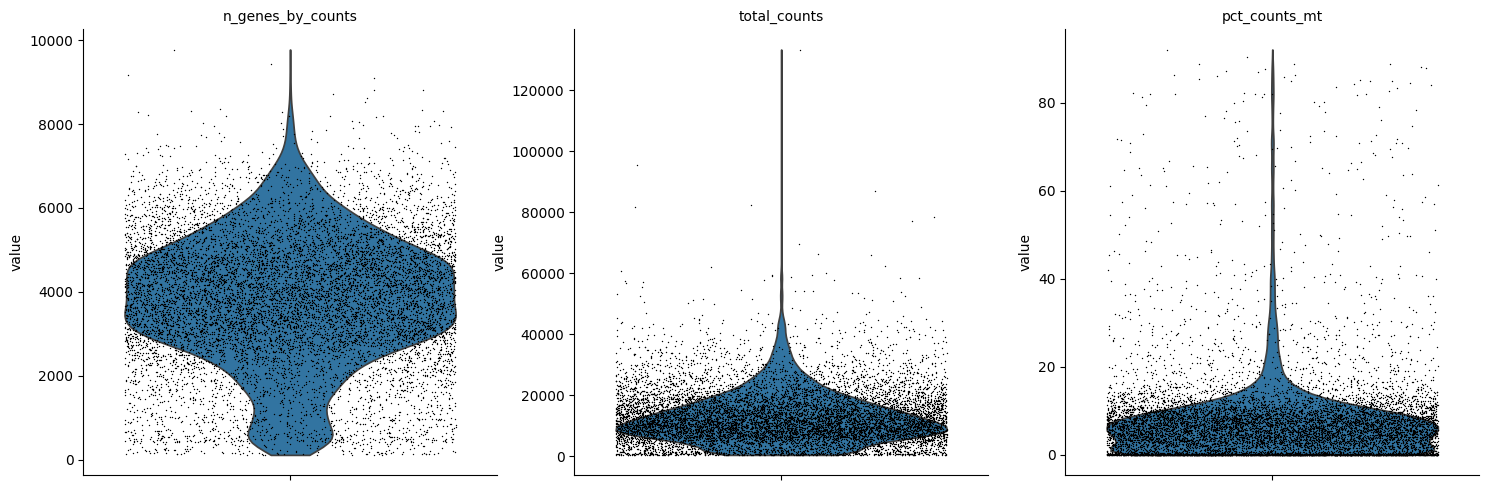

In [ ]:
sc.pl.violin(
    kim_d53,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

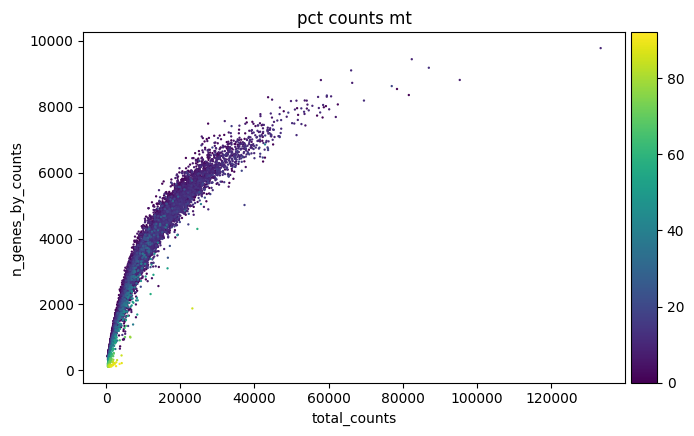

In [ ]:
sc.pl.scatter(kim_d53, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs. For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def assign_outliers(adata):
  def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

  adata.obs["outlier"] = (
      is_outlier(adata, "log1p_total_counts", 3)
      | is_outlier(adata, "log1p_n_genes_by_counts", 3)
      | is_outlier(adata, "pct_counts_in_top_20_genes", 3)
      | is_outlier(adata, "pct_counts_mt", 3)
      | (adata.obs["pct_counts_mt"] > 20)
  )

assign_outliers(kim_d53)
kim_d53.obs.outlier.value_counts()

outlier
False    8631
True     1999
Name: count, dtype: int64

Apply thresholds

In [ ]:
kim_d53 = kim_d53[~kim_d53.obs.outlier].copy()

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

We will generate a preliminary UMAP on the QC-passed dataset before cell type annotation.

In [ ]:
def generate_umap(adata):
  sc.pp.normalize_total(adata)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=2000)
  sc.tl.pca(adata)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  return adata

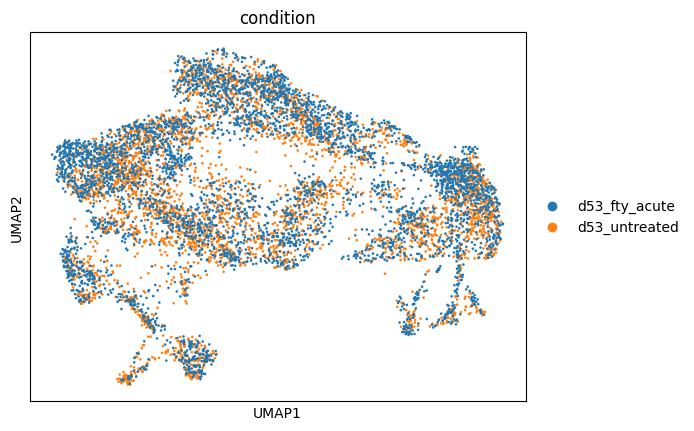

In [ ]:
kim_d53 = generate_umap(kim_d53)
sc.pl.umap(kim_d53, color='condition')

# Kim d77 samples - Data read-in

Read in Cellranger output files for day 77 untreated + chronic fentanyl samples and save as .h5ad.gz files

In [ ]:
sample1_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH003_Day77_Untreated"
adata1 = sc.read_10x_mtx(sample1_path, var_names="gene_symbols", cache=True)
adata1.obs["Sample"] = "kim_day77_untreated"
adata1.obs["condition"] = "d77_untreated"
adata1.obs.index = [f"d77_ut_{barcode}" for barcode in adata1.obs.index]
adata1.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ut.h5ad.gz", compression="gzip")

sample2_path = "/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Kim_KH004_Day77_FTY_Chronic"
adata2 = sc.read_10x_mtx(sample2_path, var_names="gene_symbols", cache=True)
adata2.obs["Sample"] = "kim_d77_fty_chronic"
adata2.obs["condition"] = "d77_fty_chronic"
adata2.obs.index = [f"d77_fty_{barcode}" for barcode in adata2.obs.index]
adata2.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_fty.h5ad.gz", compression="gzip")

Concatenate samples into single `AnnData` object and save

In [ ]:
adata_combined = sc.concat([adata1, adata2], label="orig_sample", keys=["sample3", "sample4"])
adata_combined

AnnData object with n_obs × n_vars = 10033 × 33538
    obs: 'Sample', 'condition', 'orig_sample'

In [ ]:
adata_combined.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz", compression="gzip")

In [ ]:
del adata1, adata2, adata_combined
gc.collect()

135714

# Kim d77 samples - QC

Read in file

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz")

Store raw counts and save file

In [ ]:
kim_d77.raw = kim_d77.copy()
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_combined.h5ad.gz", compression="gzip")

We will begin QC by calculating common QC metrics with `scanpy.pp.calculate_qc_metrics()`. We will also label mitochondrial, ribosomal, and hemoglobin genes.

In [ ]:
def qc_metrics(adata):
  # mitochondrial genes, "MT-" for human, "Mt-" for mouse
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
  # ribosomal genes
  adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
  # hemoglobin genes
  adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)

qc_metrics(kim_d77)

Inspect plots

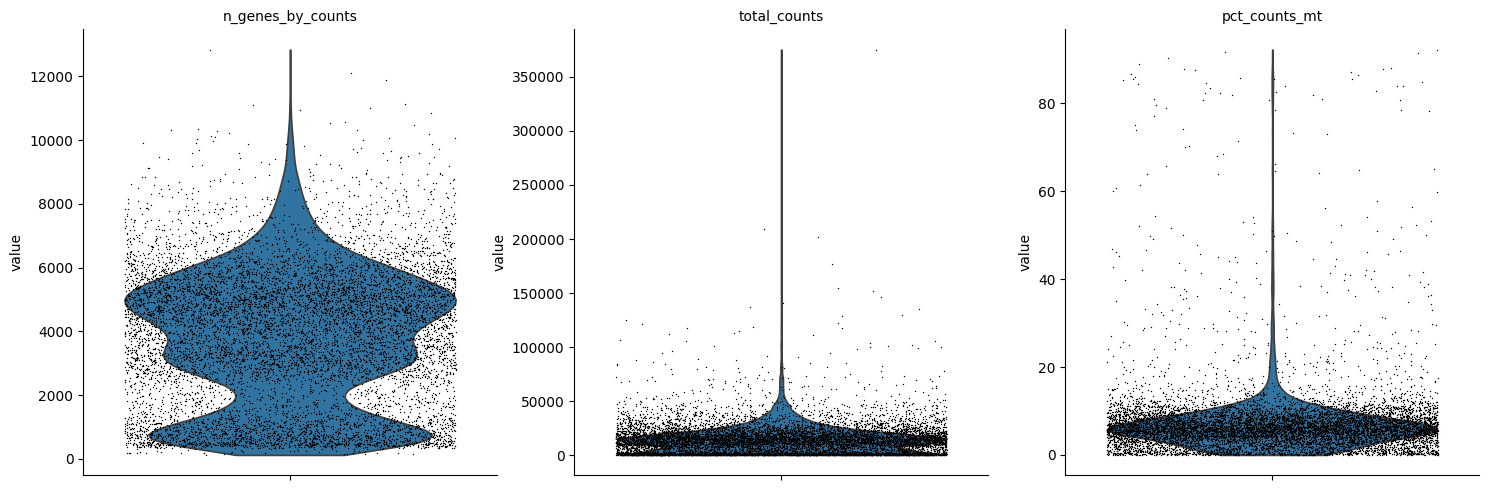

In [ ]:
sc.pl.violin(
    kim_d77,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

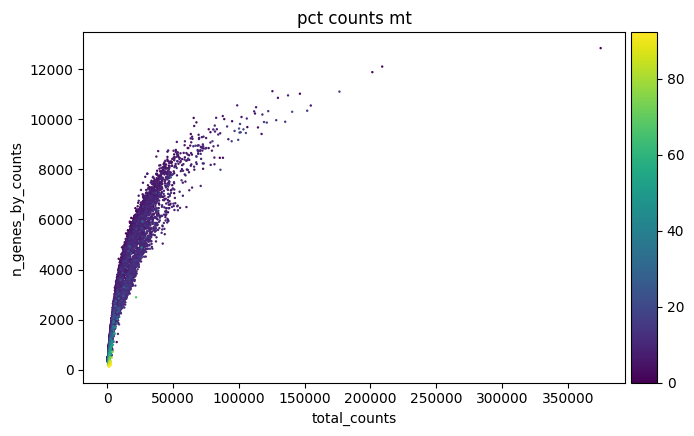

In [ ]:
sc.pl.scatter(kim_d77, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

To filter out low-quality cells, we will use automatic thresholding via MAD (median absolute deviations) following the [Single-Cell Best Practices](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) tutorial. We will mark cells as outliers if they differ by 3 MADs. For filtering out cells with a high percentage of mitochondrial genes, we will use 3 MADs. We will also manually set a threshold to filter out cells with >20% mitochondrial genes, consistent with brain organoid transcriptomic studies [Vertesy et al (2022)](https://www.embopress.org/doi/full/10.15252/embj.2022111118) and [Fleck et al (2023)](https://www.nature.com/articles/s41586-022-05279-8).

In [ ]:
def assign_outliers(adata):
  def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

  adata.obs["outlier"] = (
      is_outlier(adata, "log1p_total_counts", 3)
      | is_outlier(adata, "log1p_n_genes_by_counts", 3)
      | is_outlier(adata, "pct_counts_in_top_20_genes", 3)
      | is_outlier(adata, "pct_counts_mt", 3)
      | (adata.obs["pct_counts_mt"] > 20)
  )

assign_outliers(kim_d77)
kim_d77.obs.outlier.value_counts()

outlier
False    7481
True     2552
Name: count, dtype: int64

Apply thresholds

In [ ]:
kim_d77 = kim_d77[~kim_d77.obs.outlier].copy()

We will save the `AnnData` object with the cell barcodes and genes that passed QC as a `.h5ad.gz` file.

In [ ]:
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz", compression="gzip")

We will generate a preliminary UMAP on the QC-passed dataset before cell type annotation.

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz")

In [ ]:
def generate_umap(adata):
  sc.pp.normalize_total(adata)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=2000)
  sc.tl.pca(adata)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  return adata

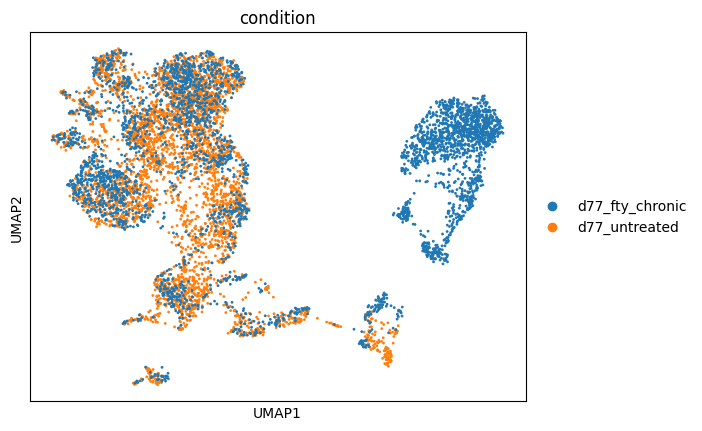

In [ ]:
kim_d77 = generate_umap(kim_d77)
sc.pl.umap(kim_d77, color='condition')

# Cell type annotation - preparing reference dataset

Kim et al performed cell type annotation by co-clustering with an annotated fetal midbrain scRNA-seq reference dataset from La Manno et al (2016). We will use the Python implementation of Symphony ([Kang et al 2021](https://)), symphonypy, to perform reference-based cell type annotation following the [tutorial](https://symphonypy.readthedocs.io/en/latest/Symphonypy_simple_tutorial.html) in the documentation.

We want to recapitulate the cell type clustering performed by Kim et al, where they found the following cell types:
-  DA (dopaminergic neurons)
-  Endo (endothelial cells)
-  Gaba (GABAergic neurons)
-  Mgl (microglia)
-  Nb (neuroblasts?)
-  NProg (neuronal progenitor)
-  OMTN (oculomotor and trochlear nucleus)
-  Peric (pericytes)
-  Prog (progenitor)
-  Rgl (radial glia-like cells)
-  RN (red nucleus neurons)
-  Sert (serotonergic neurons)

## Read in La Manno et al dataset and create AnnData object

We want to create an AnnData object from the La Manno et al dataset. We will read in the La Manno et al dataset `.cef.txt` file. We will omit the first few header rows containing sample metadata from the `DataFrame` and read those in separately.

In [ ]:
la_manno_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE76381_EmbryoMoleculeCounts.cef.txt",
                            sep="\t", header=3, index_col=0)

In [ ]:
la_manno_df.head()

Timepoint  week_7  week_7.1  ...  week_8.328  week_8.329  week_8.330
Gene                     NaN     NaN       NaN  ...         NaN         NaN         NaN
DDX11L1                  NaN     0.0       0.0  ...         0.0         0.0         0.0
WASH7P_p1                NaN     0.0       0.0  ...         0.0         0.0         0.0
LINC01002_loc4           NaN     0.0       0.0  ...         0.0         0.0         0.0
LOC100133331_loc1        NaN     1.0       0.0  ...         0.0         0.0         0.0

[5 rows x 1978 columns]

This is a gene-by-cell matrix, so we need to slice out the raw counts and transpose them so we can save them in the `.X` of the AnnData object.

In [ ]:
counts_start_row, counts_start_col = 1, 1
counts = la_manno_df.iloc[counts_start_row:, counts_start_col:].values.astype(np.float32)
counts[:5, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
counts = np.transpose(counts)
counts[:5, :5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

Get gene names to create `.var` of AnnData object

In [ ]:
genes = la_manno_df.index.tolist()[1:]
print(f"genes (length {len(genes)}): {genes[:5]}...")

genes (length 19531): ['DDX11L1', 'WASH7P_p1', 'LINC01002_loc4', 'LOC100133331_loc1', 'LOC100132287_loc2']...


Extract metadata from La Manno txt file to create `.obs` of AnnData object

In [ ]:
with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE76381_EmbryoMoleculeCounts.cef.txt") as f:
  txt = f.readlines()
  header = list()
  for i in range(4):
    header.append(txt[i].strip().split("\t"))
for i in range(4):
  print(f"header row {header[i][0]}, length {len(header[i])}, first few entries {header[i][:7]}")
cell_ids = header[1][1:]
print(f"cell_ids (length {len(cell_ids)}): {cell_ids[:5]} ...")
cell_types = header[2][1:]
print(f"cell_types (length {len(cell_types)}): {cell_types[:5]} ...")
time_points = header[3][1:]
print(f"timepoints (length {len(time_points)}): {time_points[:5]} ...")

header row CEF, length 7, first few entries ['CEF', '0', '1', '3', '19531', '1977', '0']
header row Cell_ID, length 1978, first few entries ['Cell_ID', '1772067_089_A01', '1772067_089_A02', '1772067_089_A03', '1772067_089_A04', '1772067_089_A05', '1772067_089_A06']
header row Cell_type, length 1978, first few entries ['Cell_type', 'hMgl', 'hRgl2a', 'Unk', 'hNProg', 'hProgBP', 'hProgM']
header row Timepoint, length 1978, first few entries ['Timepoint', 'week_7', 'week_7', 'week_7', 'week_7', 'week_7', 'week_7']
cell_ids (length 1977): ['1772067_089_A01', '1772067_089_A02', '1772067_089_A03', '1772067_089_A04', '1772067_089_A05'] ...
cell_types (length 1977): ['hMgl', 'hRgl2a', 'Unk', 'hNProg', 'hProgBP'] ...
timepoints (length 1977): ['week_7', 'week_7', 'week_7', 'week_7', 'week_7'] ...


Create `AnnData` object for La Manno et al dataset:

In [ ]:
lamanno_adata = sc.AnnData(X=counts, var=pd.DataFrame(index=genes), obs=pd.DataFrame(index=cell_ids))

Add cell types and timepoints as metadata to `.obs`:

In [ ]:
print(len(cell_types), len(time_points), len(lamanno_adata.obs))

1977 1977 1977


In [ ]:
lamanno_adata.obs['cell_type'] = cell_types
lamanno_adata.obs['time_point'] = time_points

In [ ]:
lamanno_adata

AnnData object with n_obs × n_vars = 1977 × 19531
    obs: 'cell_type', 'time_point'

Store raw counts

In [ ]:
lamanno_adata.raw = lamanno_adata.copy()

Save file:

In [ ]:
lamanno_adata.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata.h5ad.gz", compression="gzip")

## Preprocess La Manno dataset according to Symphony tutorial

QC was performed on the La Manno dataset before it was uploaded to GEO. We can start preprocessing immediately.

In [ ]:
lamanno_adata = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata.h5ad.gz")
lamanno_adata

AnnData object with n_obs × n_vars = 1977 × 19531
    obs: 'cell_type', 'time_point'

In [ ]:
# Filter out "Unk" cells
lamanno_adata = lamanno_adata[lamanno_adata.obs['cell_type'] != 'Unk', :].copy()
print(lamanno_adata.obs["cell_type"].unique().tolist())

['hMgl', 'hRgl2a', 'hNProg', 'hProgBP', 'hProgM', 'hOMTN', 'hDA0', 'hNbM', 'hProgFPL', 'hEndo', 'hProgFPM', 'hRgl2b', 'hNbML5', 'hRgl3', 'hRN', 'hPeric', 'hDA1', 'hRgl1', 'hGaba', 'hDA2', 'hSert', 'hNbGaba', 'hNbML1', 'hRgl2c', 'hOPC']


In [ ]:
# Update cell types in La Manno dataset based on Kim et al cell type groupings
cell_type_mapping = {'hEndo': 'Endo', 'hPeric': 'Peric', 'hMgl': 'Mgl', 'hOPC': 'OPC',
                     'hRgl2c': 'Rgl', 'hRgl2b': 'Rgl', 'hRgl2a': 'Rgl', 'hRgl3': 'Rgl', 'hRgl1': 'Rgl',
                     'hProgM': 'Prog', 'hProgBP': 'Prog', 'hProgFPL': 'Prog', 'hProgFPM': 'Prog', 'hNProg': 'NProg',
                     'hNbM': 'Nb', 'hNbML1': 'Nb', 'hRN': 'RN', 'hNbML5': 'Nb', 'hDA0': 'DA', 'hDA1': 'DA', 'hDA2': 'DA',
                     'hNbGaba': 'Nb', 'hGaba': 'Gaba', 'hSert': 'Sert', 'hOMTN': 'OMTN'}
# Apply the mapping to the cell_type column in adata_ref.obs
lamanno_adata.obs['cell_type'] = lamanno_adata.obs['cell_type'].map(cell_type_mapping).fillna(lamanno_adata.obs['cell_type'])
print(list(lamanno_adata.obs["cell_type"].unique()))

['Mgl', 'Rgl', 'NProg', 'Prog', 'OMTN', 'DA', 'Nb', 'Endo', 'RN', 'Peric', 'Gaba', 'Sert', 'OPC']


In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp_cluster(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)
  sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
  return adata

In [ ]:
lamanno_adata = symphony_pp_cluster(lamanno_adata)

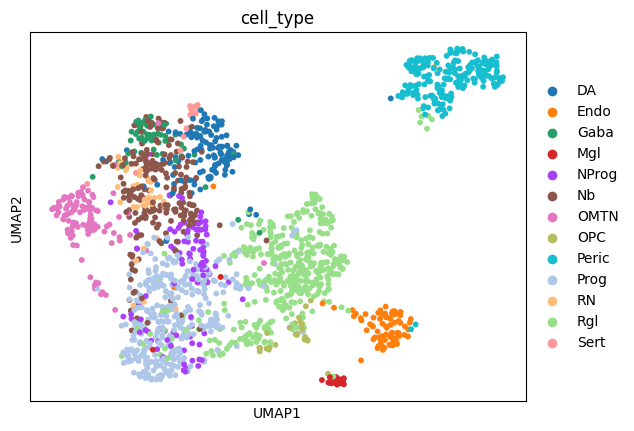

In [ ]:
sc.pl.umap(lamanno_adata, color="cell_type")

Save La Manno preprocessed reference dataset

In [ ]:
lamanno_adata.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata_pp_ref.h5ad.gz", compression="gzip")

# Kim d53 samples - annotate cell types

Read in QC-passed data

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz")

Save raw counts

In [ ]:
kim_d53.raw = kim_d53.copy()
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_qc.h5ad.gz", compression="gzip")

Preprocess Kim d53 dataset the same way as La Manno dataset

In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  return adata

In [ ]:
kim_d53 = symphony_pp(kim_d53)

Perform annotation on Kim d53 dataset with Symphony

In [ ]:
def run_symphony(query, ref):
  # Running Symphony
  sp.tl.map_embedding(
      adata_query=query,
      adata_ref=ref
  )
  # Mapping UMAP coordinates
  sp.tl.ingest(
      adata_query=query,
      adata_ref=ref,
      use_rep="X_pca",
  )
  # Labels prediction
  sp.tl.transfer_labels_kNN(
      adata_query=query,
      adata_ref=ref,
      ref_labels=["cell_type"],
      ref_basis="X_pca",
      query_basis="X_pca",
  )

In [ ]:
run_symphony(kim_d53, lamanno_adata)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/symphonypy/tools.py:250: FutureWarning: The specified parameters ('inplace',) are no longer positional. Please specify them like `inplace=True`
  return ing.to_adata(inplace)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Visualize UMAPs of Kim d53 and La Manno data colored by cell type

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

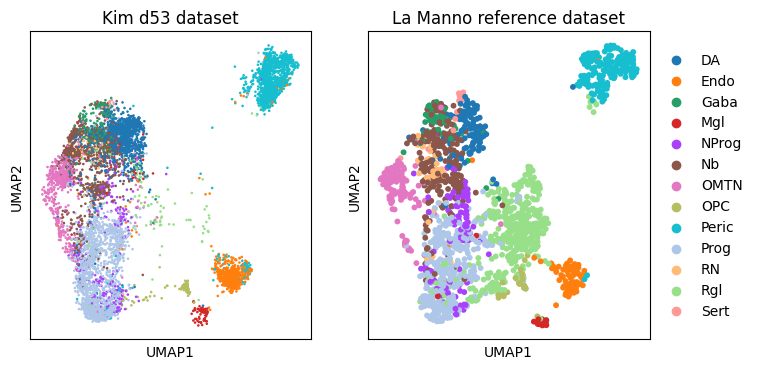

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    kim_d53,
    color="cell_type",
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    title="La Manno reference dataset",
    ax=axes[1],
    show=False,
)

Visualize UMAP of Kim d53 data colored by treatment condition

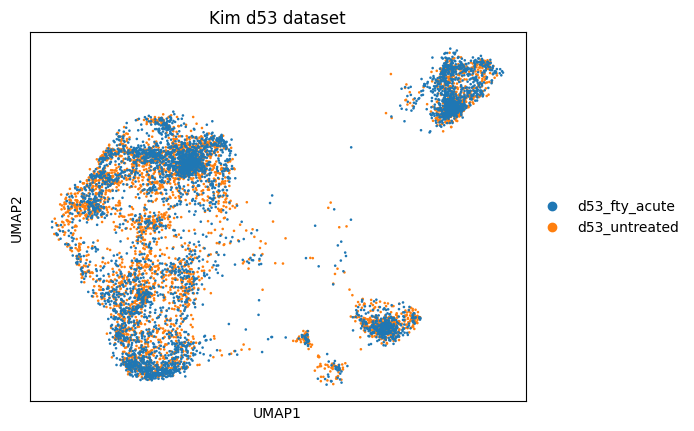

In [ ]:
sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53 dataset"
)

Save annotated dataset

In [ ]:
kim_d53.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz", compression="gzip")

# Kim d77 samples - annotate cell types

Read in QC-passed data

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz")

Save raw counts

In [ ]:
kim_d77.raw = kim_d77.copy()
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_qc.h5ad.gz", compression="gzip")

Preprocess Kim d77 dataset the same way as La Manno dataset

In [ ]:
# Preprocessing and clustering based on Symphonypy tutorial
def symphony_pp(adata):
  sc.pp.normalize_total(adata, target_sum=1e5)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, n_top_genes=3000)
  adata = adata[:, adata.var.highly_variable].copy()
  sc.pp.scale(adata, max_value=10)
  sc.pp.pca(adata, n_comps=30, zero_center=False)
  return adata

In [ ]:
kim_d77 = symphony_pp(kim_d77)

Perform annotation on Kim d77 dataset with Symphony

In [ ]:
def run_symphony(query, ref):
  # Running Symphony
  sp.tl.map_embedding(
      adata_query=query,
      adata_ref=ref
  )
  # Mapping UMAP coordinates
  sp.tl.ingest(
      adata_query=query,
      adata_ref=ref,
      use_rep="X_pca",
  )
  # Labels prediction
  sp.tl.transfer_labels_kNN(
      adata_query=query,
      adata_ref=ref,
      ref_labels=["cell_type"],
      ref_basis="X_pca",
      query_basis="X_pca",
  )

In [ ]:
run_symphony(kim_d77, lamanno_adata)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/symphonypy/tools.py:250: FutureWarning: The specified parameters ('inplace',) are no longer positional. Please specify them like `inplace=True`
  return ing.to_adata(inplace)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Visualize UMAPs for cell type annotation

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

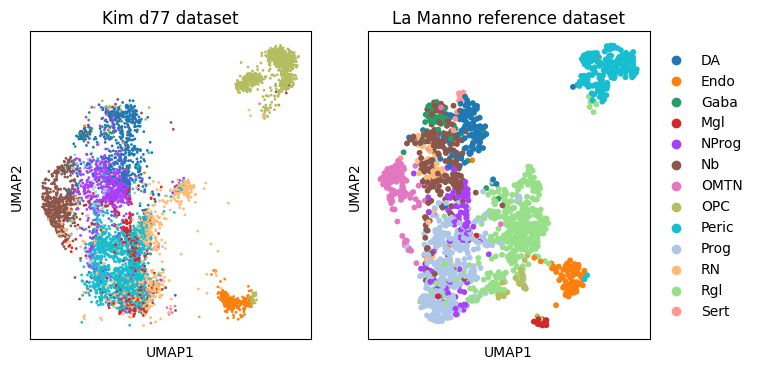

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    title="Kim d77 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    title="La Manno reference dataset",
    ax=axes[1],
    show=False,
)

Visualize Kim d77 UMAP colored by treatment condition

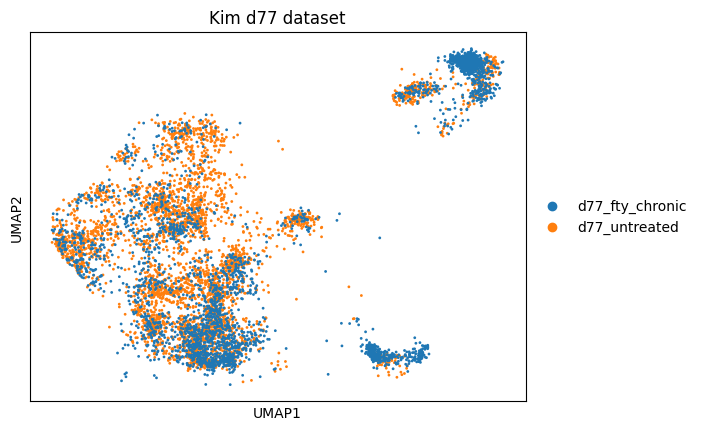

In [ ]:
sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77 dataset"
)

Save annotated dataset

In [ ]:
kim_d77.write("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz", compression="gzip")

# Kim both datasets - visualize UMAPs after cell type annotation

In [ ]:
lamanno_adata = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/lamanno_adata_pp_ref.h5ad.gz")
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz")
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")

Visualize cell type annotation with reference dataset

In [ ]:
all_cell_types = list(lamanno_adata.obs["cell_type"].unique())
print(all_cell_types)
cmap = plt.get_cmap("tab20")
cell_palette = {all_cell_types[i]: cmap(i) for i in range(len(all_cell_types))}
#cell_palette = {cell_type: cmap(i / len(all_cell_types)) for i, cell_type in enumerate(all_cell_types)}

['Mgl', 'Rgl', 'NProg', 'Prog', 'OMTN', 'DA', 'Nb', 'Endo', 'RN', 'Peric', 'Gaba', 'Sert', 'OPC']


In [ ]:
# Color palette
all_cell_types = ["DA", "Endo", "Gaba", "Mgl", "NProg", "Nb", "OMTN", "OPC", "Peric", "Prog", "RN", "Rgl", "Sert"]
base_colors = plt.get_cmap("tab10").colors
# Define additional colors
extra_colors = sns.color_palette("husl", 3)  # 'husl' generates distinct colors
# Combine them into one palette
custom_palette = list(base_colors) + list(extra_colors)
cell_palette = {cell: color for cell, color in zip(all_cell_types, custom_palette)}

<Axes: title={'center': 'La Manno reference dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

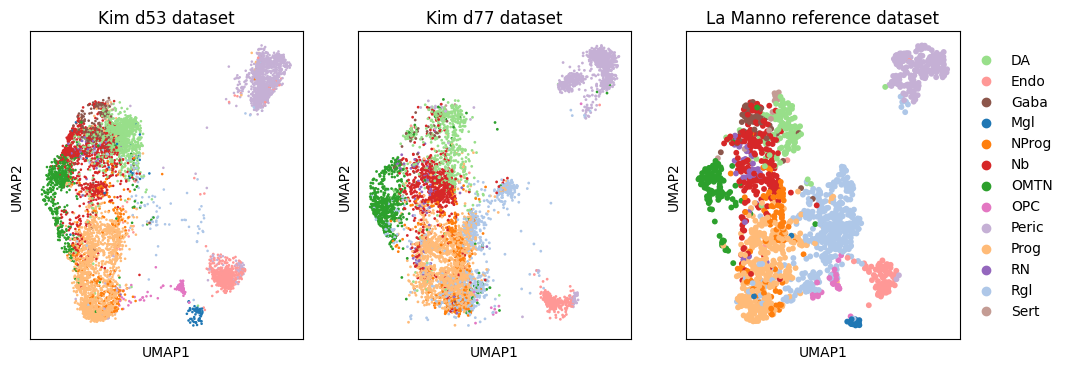

In [ ]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

sc.pl.umap(
    kim_d53,
    color="cell_type",
    palette=cell_palette,
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    palette=cell_palette,
    title="Kim d77 dataset",
    ax=axes[1],
    show=False,
    legend_loc=None,
)

sc.pl.umap(
    lamanno_adata,
    color="cell_type",
    palette=cell_palette,
    title="La Manno reference dataset",
    ax=axes[2],
    show=False,
)

Visualize treatment conditions and time points

<Axes: title={'center': 'Kim d77 dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

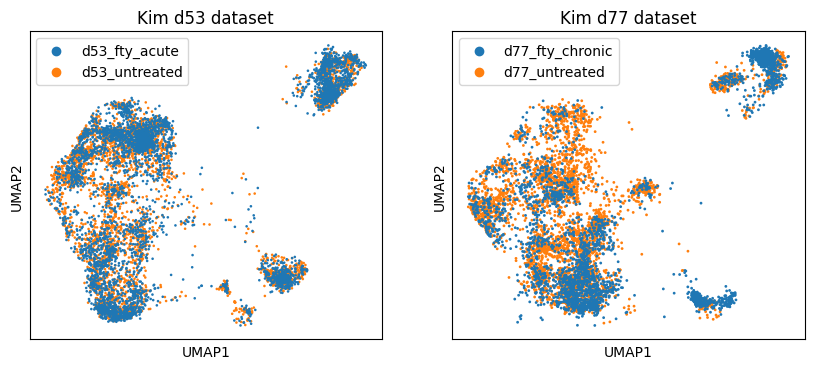

In [ ]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53 dataset",
    ax=axes[0],
    show=False,
    legend_loc="best"
)

sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77 dataset",
    ax=axes[1],
    show=False,
    legend_loc="best"
)

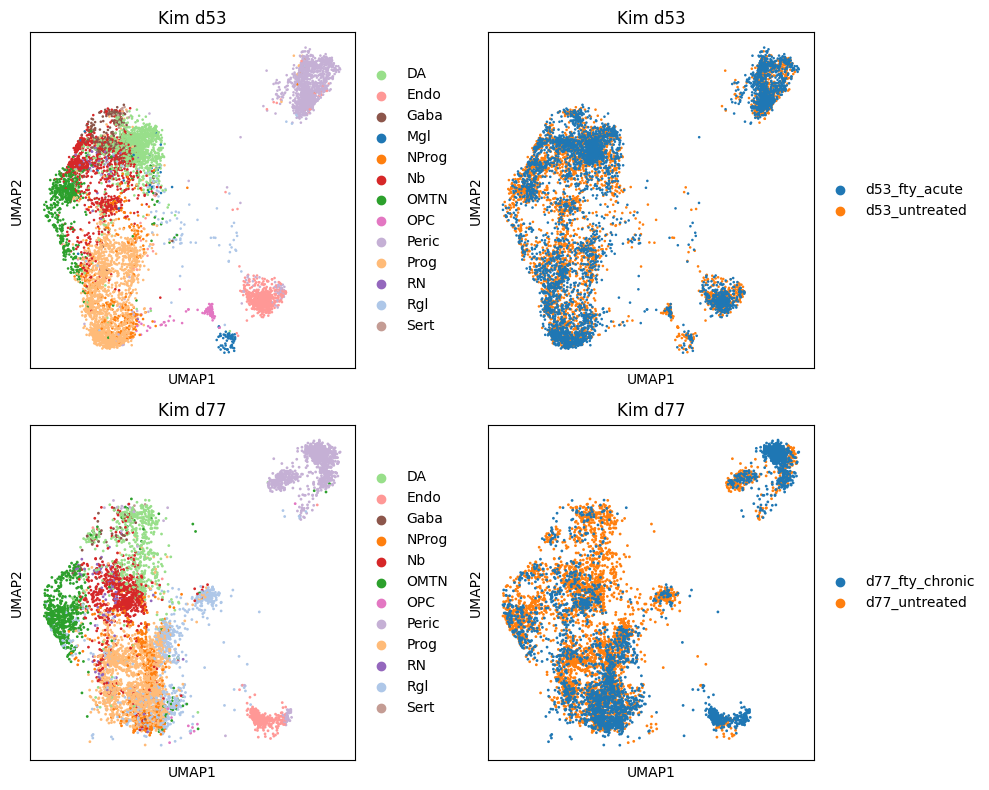

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sc.pl.umap(
    kim_d53,
    color="cell_type",
    palette=cell_palette,
    title="Kim d53",
    ax=axes[0][0],
    show=False
)

sc.pl.umap(
    kim_d53,
    color="condition",
    title="Kim d53",
    ax=axes[0][1],
    show=False
)

sc.pl.umap(
    kim_d77,
    color="cell_type",
    palette=cell_palette,
    title="Kim d77",
    ax=axes[1][0],
    show=False
)

sc.pl.umap(
    kim_d77,
    color="condition",
    title="Kim d77",
    ax=axes[1][1],
    show=False
)
fig.tight_layout()

# Kim d53 - generating pseudobulk dataset and differential expression analysis (DEA)

Read in data

In [ ]:
kim_d53 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d53_ann.h5ad.gz")

## Generate Kim d53 annotated single-rep pseudobulk dataset

First, we will generate a pseudobulk profile for each cell type with no pseudoreplicates. Because `decoupler.get_pseudobulk()` uses raw counts, we will reassign the raw counts to X:

In [ ]:
kim_d53.X = kim_d53.raw[:, kim_d53.var_names].X.copy()

View cell types:

In [ ]:
cell_type_counts = kim_d53.obs['cell_type'].value_counts()
print(cell_type_counts)

cell_type
Prog     1875
Peric    1839
DA       1548
Nb       1051
Endo      775
OMTN      547
Gaba      309
NProg     277
OPC       123
Rgl       115
Mgl       101
RN         55
Sert       16
Name: count, dtype: int64


Use `decoupler` to generate pseudobulk profile (without pseudoreplicates) for the 2 samples and 13 cell types in `kim_d53`

In [ ]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    kim_d53,
    sample_col='condition',
    groups_col='cell_type',
    use_raw=True,
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 25 × 2500
    obs: 'condition', 'cell_type', 'Sample', 'orig_sample', 'outlier', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'psbulk_props'

PCA

In [ ]:
def pseudobulk_pca(pdata):
  # Store raw counts in layers
  pdata.layers['counts'] = pdata.X.copy()

  # Normalize, scale and compute pca
  sc.pp.normalize_total(pdata, target_sum=1e4)
  sc.pp.log1p(pdata)
  sc.pp.scale(pdata, max_value=10)
  sc.tl.pca(pdata)

  # Return raw counts to X
  dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [ ]:
pseudobulk_pca(pdata)

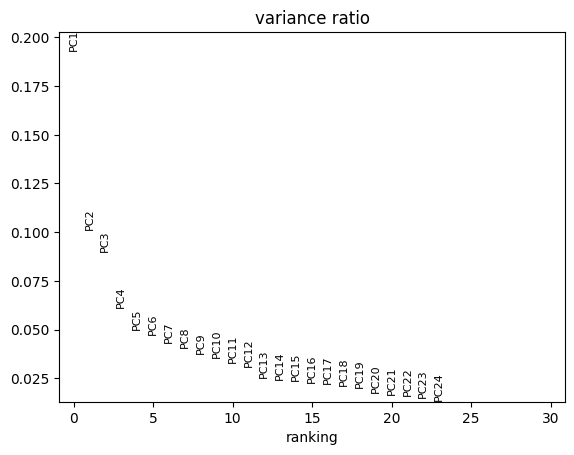

In [ ]:
sc.pl.pca_variance_ratio(pdata)

In order to have a better overview of the association of PCs with sample metadata, let’s perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples


In [ ]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['condition', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

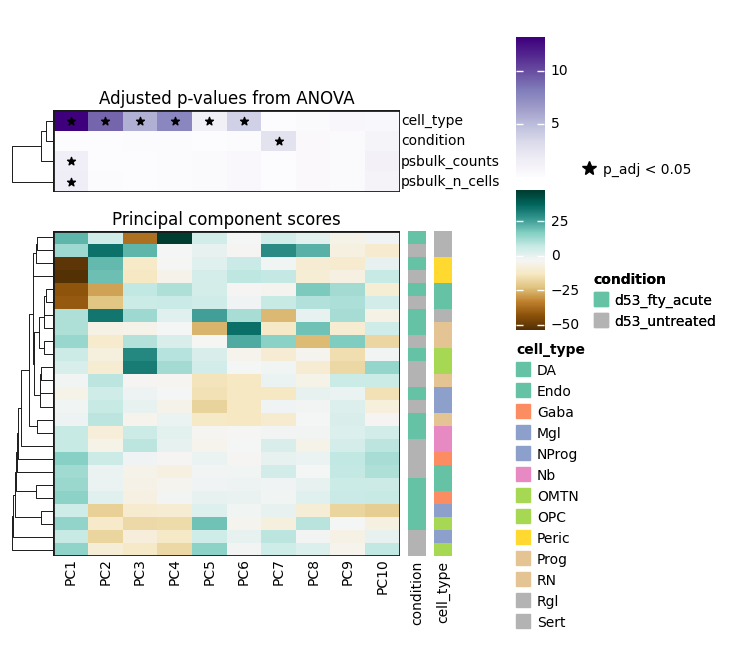

In [ ]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'cell_type'], # which sample annotations to plot
    titles=['Principal component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

## Kim d53 pseudobulk - differential expression analysis with `PyDESeq2`

Initialize `DeseqDataSet` object

In [ ]:
kim_d53_dds = DeseqDataSet(
    adata=pdata,
    design='~condition'
)
kim_d53_dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 7.13 seconds.

Fitting dispersion trend curve...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 6.22 seconds.

Fitting LFCs...
... done in 9.38 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 62 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting LFCs...
... done in 0.11 seconds.



Run statistical tests

In [ ]:
kim_d53_ds = DeseqStats(kim_d53_dds, contrast=["condition", "d53_fty_acute", "d53_untreated"])
kim_d53_ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition d53_fty_acute vs d53_untreated
             baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG        73.783687        0.179835  0.220968  0.813851  0.415730  0.9997
A2M          0.123790        0.049306  2.481005  0.019873  0.984144  0.9997
A2ML1-AS2    0.489812       -0.246040  0.804313 -0.305901  0.759680  0.9997
AAMDC       60.461114       -0.040455  0.124778 -0.324213  0.745777  0.9997
AANAT      137.434448        0.408666  0.173447  2.356148  0.018466  0.9997
...               ...             ...       ...       ...       ...     ...
ZNF679       2.023071        0.265253  0.493255  0.537760  0.590743  0.9997
ZNF716       0.281445       -0.093150  2.446817 -0.038070  0.969632  0.9997
ZNF766       0.022608        0.289497  3.223929  0.089796  0.928449  0.9997
ZNF860     189.217938        0.002787  0.167252  0.016665  0.986704  0.9997
ZWINT        1.355299        0.552025  0.667193  0.827383  0.408020  0.9997

[2500 ro

... done in 0.69 seconds.



Perform LFC shrinkage before further analysis

In [ ]:
kim_d53_ds.lfc_shrink(coeff="condition[T.d53_untreated]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.d53_untreated]
             baseMean  log2FoldChange     lfcSE      stat    pvalue    padj
A1BG        73.783687       -0.007469  0.060802  0.813851  0.415730  0.9997
A2M          0.123790        0.000476  0.080740  0.019873  0.984144  0.9997
A2ML1-AS2    0.489812        0.001490  0.068705 -0.305901  0.759680  0.9997
AAMDC       60.461114        0.004762  0.058040 -0.324213  0.745777  0.9997
AANAT      137.434448       -0.031806  0.077838  2.356148  0.018466  0.9997
...               ...             ...       ...       ...       ...     ...
ZNF679       2.023071        0.000200  0.063314  0.537760  0.590743  0.9997
ZNF716       0.281445        0.000231  0.072008 -0.038070  0.969632  0.9997
ZNF766       0.022608        0.000297  0.098726  0.089796  0.928449  0.9997
ZNF860     189.217938       -0.000229  0.059514  0.016665  0.986704  0.9997
ZWINT        1.355299       -0.002288  0.063337  0.827383  0.408020  0.9997

[2500 rows x 6 

... done in 7.66 seconds.



Assign results DataFrame to variable

In [ ]:
kim_d53_results = kim_d53_ds.results_df

Volcano plots

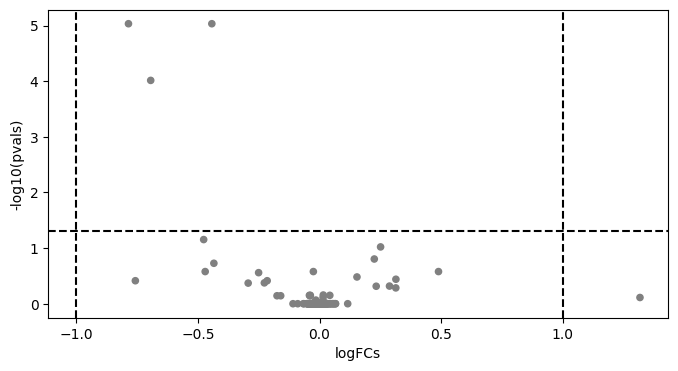

In [ ]:
# |LFC| > 1
dc.plot_volcano_df(
    kim_d53_results,
    x='log2FoldChange',
    y='padj',
    lFCs_thr=1,
    figsize=(8, 4)
)

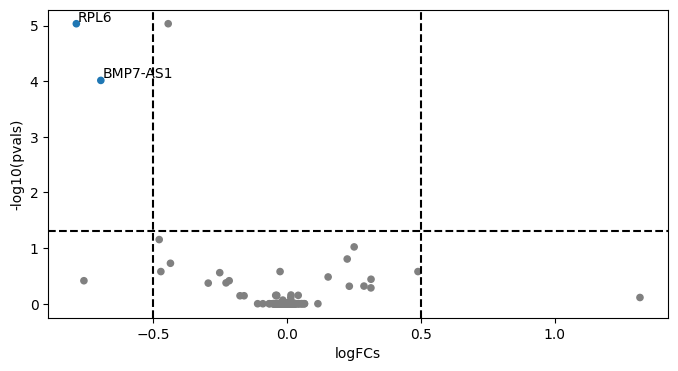

In [ ]:
# |LFC| > 0.5
dc.plot_volcano_df(
    kim_d53_results,
    x='log2FoldChange',
    y='padj',
    top=3,
    figsize=(8, 4)
)

Display differentially expressed genes

In [ ]:
kim_d53_results.sort_values('log2FoldChange', ascending = False, inplace=True)
kim_d53_degs_df = kim_d53_results[kim_d53_results["padj"] <= 0.05]
kim_d53_degs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
IER2      153.504279       -0.442801  0.081965  5.858706  4.664890e-09   
BMP7-AS1   31.123163       -0.694168  0.145691  5.300011  1.157959e-07   
RPL6       45.295739       -0.785600  0.148047  5.781822  7.389593e-09   

              padj  
IER2      0.000009  
BMP7-AS1  0.000096  
RPL6      0.000009

# Kim d77 - generating pseudobulk dataset and DEA

## Generate Kim d77 annotated single-rep pseudobulk dataset

Read in data

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")

First, we will generate a pseudobulk profile for each cell type with no pseudoreplicates. Because `decoupler.get_pseudobulk()` uses raw counts, we will reassign the raw counts to X:

In [ ]:
kim_d77.X = kim_d77.raw[:, kim_d77.var_names].X.copy()

View cell types:

In [ ]:
cell_type_counts = kim_d77.obs['cell_type'].value_counts()
print(cell_type_counts)

cell_type
Prog     1856
Peric    1658
Rgl       883
Nb        800
OMTN      632
DA        613
NProg     489
Endo      366
RN        126
Gaba       43
OPC        11
Sert        4
Name: count, dtype: int64


Use `decoupler` to generate pseudobulk profile (without pseudoreplicates) for the 2 samples and 12 cell types in `kim_d77`

In [ ]:
# Get filtered pseudo-bulk profile
pdata_d77 = dc.get_pseudobulk(
    kim_d77,
    sample_col='condition',
    groups_col='cell_type',
    use_raw=True,
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata_d77

AnnData object with n_obs × n_vars = 20 × 2427
    obs: 'condition', 'cell_type', 'Sample', 'orig_sample', 'outlier', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    layers: 'psbulk_props'

Only 10 cell types fulfiilled the minimum requirement of 10 cells and 1000 counts across all cells of that type. View these cell types:

In [ ]:
print(list(pdata_d77.obs["cell_type"].unique()))

['DA', 'Endo', 'Gaba', 'NProg', 'Nb', 'OMTN', 'Peric', 'Prog', 'RN', 'Rgl']


PCA

In [ ]:
def pseudobulk_pca(pdata):
  # Store raw counts in layers
  pdata.layers['counts'] = pdata.X.copy()

  # Normalize, scale and compute pca
  sc.pp.normalize_total(pdata, target_sum=1e4)
  sc.pp.log1p(pdata)
  sc.pp.scale(pdata, max_value=10)
  sc.tl.pca(pdata)

  # Return raw counts to X
  dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [ ]:
pseudobulk_pca(pdata_d77)

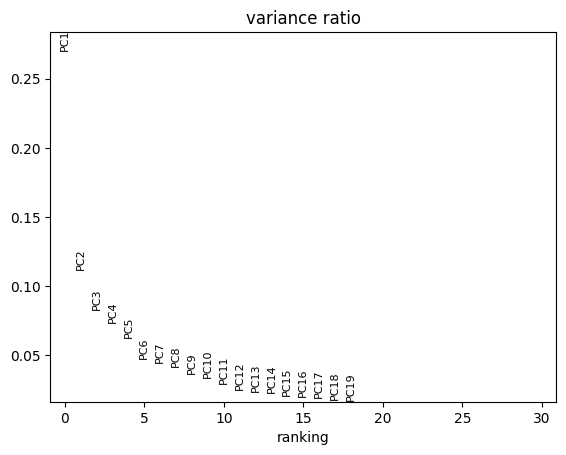

In [ ]:
sc.pl.pca_variance_ratio(pdata_d77)

In order to have a better overview of the association of PCs with sample metadata, let’s perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples


In [ ]:
dc.get_metadata_associations(
    pdata_d77,
    obs_keys = ['condition', 'cell_type', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

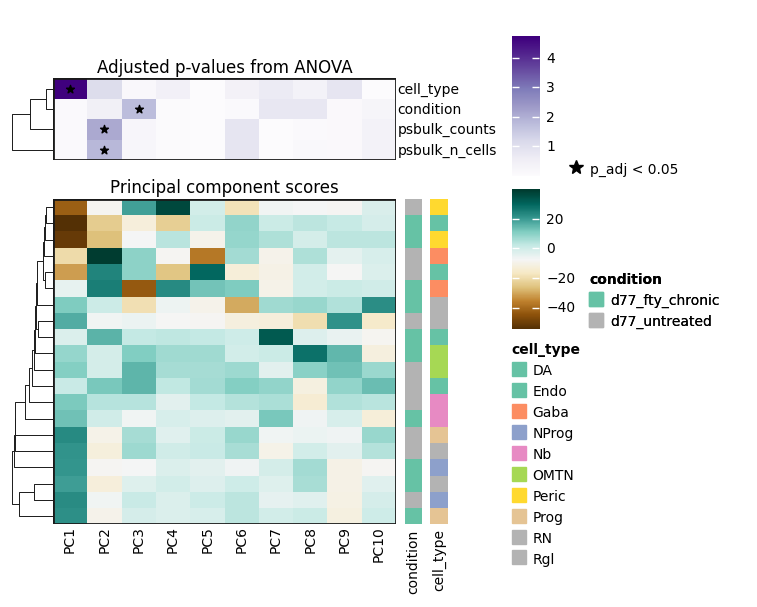

In [ ]:
dc.plot_associations(
    pdata_d77,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'cell_type'], # which sample annotations to plot
    titles=['Principal component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

In [ ]:
pdata_d77

AnnData object with n_obs × n_vars = 20 × 2427
    obs: 'condition', 'cell_type', 'Sample', 'orig_sample', 'outlier', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'pca_anova'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

## Kim d77 pseudobulk - DEA with `PyDESeq2`

Run DEA

In [ ]:
kim_d77_dds = DeseqDataSet(
    adata=pdata_d77,
    design='~condition'
)
kim_d77_dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 5.75 seconds.

Fitting dispersion trend curve...
/usr/local/lib/python3.11/dist-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 7.43 seconds.

Fitting LFCs...
... done in 3.58 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 113 outlier genes.

Fitting dispersions...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 0.44 seconds.

Fitting LFCs...
... done in 0.30 seconds.



In [ ]:
kim_d77_ds = DeseqStats(kim_d77_dds, contrast=["condition", "d77_fty_chronic", "d77_untreated"])
kim_d77_ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition d77_fty_chronic vs d77_untreated
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M       0.219192        0.097779  1.630553  0.059967  0.952182       NaN
A2ML1     0.028423       -0.047468  2.806197 -0.016915  0.986504       NaN
AANAT     1.895792       -0.448928  0.586894 -0.764922  0.444318  0.947868
ABCA1     1.294396        1.705647  1.197615  1.424202  0.154388  0.861494
ABCA13    0.145811        1.768615  3.031200  0.583470  0.559577       NaN
...            ...             ...       ...       ...       ...       ...
ZNF750    1.651168       -0.469896  0.752105 -0.624774  0.532119  0.948635
ZPLD1   101.365388       -0.362345  0.164515 -2.202510  0.027629  0.462515
ZSCAN4    0.018629        0.755861  3.308975  0.228427  0.819314       NaN
ZWINT     2.110168        0.346234  0.797675  0.434054  0.664249  0.968293
ZYG11A  389.536022        0.124642  0.165978  0.750955  0.452680  0.947868

[2427 rows x 6 col

... done in 1.55 seconds.



In [ ]:
kim_d77_ds.lfc_shrink(coeff="condition[T.d77_untreated]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.d77_untreated]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M       0.219192        0.000024  0.104192  0.059967  0.952182       NaN
A2ML1     0.028423        0.001002  0.160172 -0.016915  0.986504       NaN
AANAT     1.895792        0.007427  0.109686 -0.764922  0.444318  0.947868
ABCA1     1.294396       -0.006194  0.084142  1.424202  0.154388  0.861494
ABCA13    0.145811       -0.001609  0.076554  0.583470  0.559577       NaN
...            ...             ...       ...       ...       ...       ...
ZNF750    1.651168        0.004712  0.111899 -0.624774  0.532119  0.948635
ZPLD1   101.365388        0.099926  0.162001 -2.202510  0.027629  0.462515
ZSCAN4    0.018629       -0.000789  0.082029  0.228427  0.819314       NaN
ZWINT     2.110168       -0.002361  0.102154  0.434054  0.664249  0.968293
ZYG11A  389.536022       -0.020342  0.089607  0.750955  0.452680  0.947868

[2427 rows x 6 columns]


... done in 8.83 seconds.



In [ ]:
kim_d77_results = kim_d77_ds.results_df

In [ ]:
kim_d77_results

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M       0.219192        0.000024  0.104192  0.059967  0.952182       NaN
A2ML1     0.028423        0.001002  0.160172 -0.016915  0.986504       NaN
AANAT     1.895792        0.007427  0.109686 -0.764922  0.444318  0.947868
ABCA1     1.294396       -0.006194  0.084142  1.424202  0.154388  0.861494
ABCA13    0.145811       -0.001609  0.076554  0.583470  0.559577       NaN
...            ...             ...       ...       ...       ...       ...
ZNF750    1.651168        0.004712  0.111899 -0.624774  0.532119  0.948635
ZPLD1   101.365388        0.099926  0.162001 -2.202510  0.027629  0.462515
ZSCAN4    0.018629       -0.000789  0.082029  0.228427  0.819314       NaN
ZWINT     2.110168       -0.002361  0.102154  0.434054  0.664249  0.968293
ZYG11A  389.536022       -0.020342  0.089607  0.750955  0.452680  0.947868

[2427 rows x 6 columns]

In [ ]:
kim_d77_results.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_pseudobulk_shrank_degs.csv")

In [ ]:
kim_d77_results = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_pseudobulk_shrank_degs.csv", index_col=0)
kim_d77_results

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M       0.219192        0.000024  0.104192  0.059967  0.952182       NaN
A2ML1     0.028423        0.001002  0.160172 -0.016915  0.986504       NaN
AANAT     1.895792        0.007427  0.109686 -0.764922  0.444318  0.947868
ABCA1     1.294396       -0.006194  0.084142  1.424202  0.154388  0.861494
ABCA13    0.145811       -0.001609  0.076554  0.583470  0.559577       NaN
...            ...             ...       ...       ...       ...       ...
ZNF750    1.651168        0.004712  0.111899 -0.624774  0.532119  0.948635
ZPLD1   101.365388        0.099926  0.162001 -2.202510  0.027629  0.462515
ZSCAN4    0.018629       -0.000789  0.082029  0.228427  0.819314       NaN
ZWINT     2.110168       -0.002361  0.102154  0.434054  0.664249  0.968293
ZYG11A  389.536022       -0.020342  0.089607  0.750955  0.452680  0.947868

[2427 rows x 6 columns]

Volcano plots

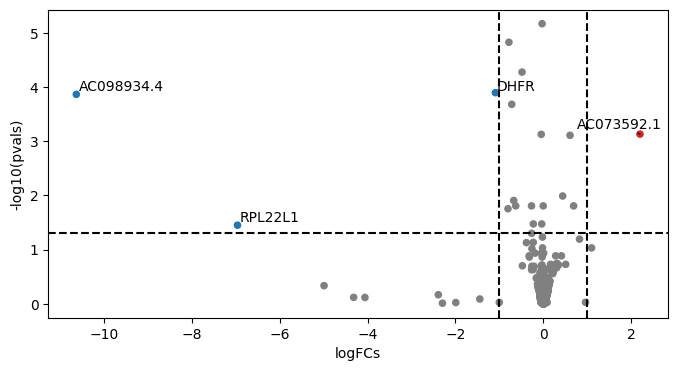

In [ ]:
# padj < 0.05, |LFC| > 1
dc.plot_volcano_df(
    kim_d77_results,
    x='log2FoldChange',
    y='padj',
    lFCs_thr=1,
    top=20,
    figsize=(8, 4)
)

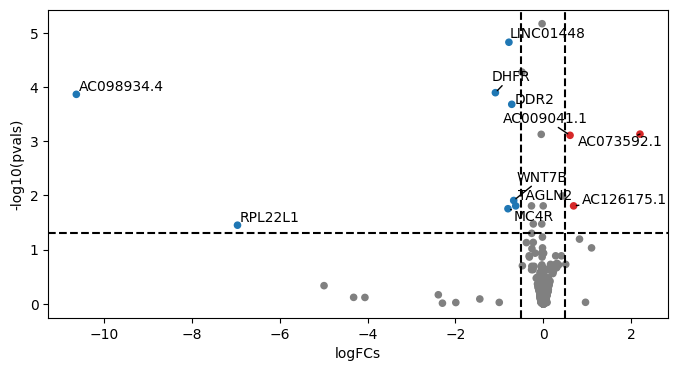

In [ ]:
# padj < 0.1, |LFC| > 0.5
dc.plot_volcano_df(
    kim_d77_results,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

Display DEGs

In [ ]:
kim_d77_results = kim_d77_ds.results_df
kim_d77_results.sort_values('log2FoldChange', ascending = False, inplace=True)
kim_d77_degs_df = kim_d77_results[kim_d77_results["padj"] <= 0.05]
kim_d77_degs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AC073592.1    20.736487        2.195434  1.079918 -4.665683  3.075930e-06   
AC126175.1    45.001606        0.686662  0.217525 -3.849388  1.184134e-04   
AC009041.1   263.824458        0.605037  0.150483 -4.603133  4.161817e-06   
PTAFR       1016.473890        0.437176  0.130273 -4.008694  6.105544e-05   
HOXD8         14.125493       -0.004815  0.079135  3.819514  1.337148e-04   
SPX           23.200972       -0.030584  0.082271  5.883257  4.022699e-09   
TYMS          12.276818       -0.038099  0.091085  3.567313  3.606612e-04   
ADCYAP1        6.061764       -0.049995  0.103425  4.636083  3.550738e-06   
CFH          131.221762       -0.230098  0.078748  3.577519  3.468707e-04   
AL139041.1   559.369294       -0.266911  0.099202  3.432836  5.973035e-04   
CELF4        206.532143       -0.271290  0.084953  3.810166  1.388734e-04   
IL13RA2      108.233288       -0.486641  0.100178  5.337217  9.438427e-08   
TAGLN2        86.385363       -0.630311  0.205136  3.809207  1.394131e-04   
WNT7B        164.376204       -0.675902  0.209572  3.940620  8.127131e-05   
DDR2        2968.461829       -0.720400  0.163932  4.949941  7.423608e-07   
LINC01448    133.115487       -0.784930  0.152768  5.633330  1.767630e-08   
MC4R          10.932221       -0.806325  0.269265  3.763082  1.678324e-04   
DHFR          93.626597       -1.092373  0.237562  5.122296  3.018374e-07   
RPL22L1       14.656045       -6.957300  0.528711  3.539205  4.013339e-04   
AC098934.4     3.996398      -10.622514  0.995099  5.066637  4.049055e-07   

                padj  
AC073592.1  0.000736  
AC126175.1  0.015559  
AC009041.1  0.000774  
PTAFR       0.010221  
HOXD8       0.015559  
SPX         0.000007  
TYMS        0.033541  
ADCYAP1     0.000743  
CFH         0.033541  
AL139041.1  0.049994  
CELF4       0.015559  
IL13RA2     0.000053  
TAGLN2      0.015559  
WNT7B       0.012368  
DDR2        0.000207  
LINC01448   0.000015  
MC4R        0.017559  
DHFR        0.000126  
RPL22L1     0.035360  
AC098934.4  0.000136

In [ ]:
kim_d77_degs_df.shape

(20, 6)

## Generate Kim d77 2-pseudorep-per-cell-type pseudobulk dataset

First, we will generate a pseudobulk profile for each cell type with two pseudoreplicates per cell type. For each cell type and each condition, we will try to generate 2 pseudoreplicates with 50 randomly chosen cells each, but if that is not possible then we will divide the cells evenly into 2 pseudoreplicates.

In [ ]:
def generate_pseudobulk_profiles(adata, n_cells=50, n_reps=2):
    pseudobulk_list = []

    # Ensure condition column exists
    if "condition" not in adata.obs.columns:
        raise ValueError("Metadata column 'condition' not found in adata.obs")

    for cell_type in adata.obs["cell_type"].unique():
        cell_type_data = adata[adata.obs["cell_type"] == cell_type]

        # Ensure cells from both conditions are represented
        for condition in cell_type_data.obs["condition"].unique():
            cond_data = cell_type_data[cell_type_data.obs["condition"] == condition]

            total_cells = cond_data.n_obs
            if total_cells < n_cells * n_reps:
                # Evenly divide the available cells
                indices = np.array_split(np.random.permutation(total_cells), n_reps)
            else:
                # Randomly sample n_cells for each replicate
                indices = [np.random.choice(total_cells, n_cells, replace=False) for _ in range(n_reps)]

            for i, idx in enumerate(indices):
                sampled_data = cond_data[idx]

                # Sum counts per gene across sampled cells
                pseudobulk_counts = np.asarray(sampled_data.layers["counts"].sum(axis=0)).reshape(1, -1)

                # Create a new AnnData object
                pseudo_adata = ad.AnnData(
                    X=pseudobulk_counts,
                    var=adata.var,
                    obs=pd.DataFrame({"cell_type": [cell_type],
                                      "condition": [condition],
                                      "sample_id": [f"{cell_type}_{condition}_rep{i+1}"]})
                )

                pseudobulk_list.append(pseudo_adata)

    # Concatenate all pseudobulk profiles
    pseudobulk_adata = ad.concat(pseudobulk_list, join="outer", merge="first")
    pseudobulk_adata.obs_names_make_unique()
    return pseudobulk_adata


In [ ]:
kim_d77.layers["counts"] = kim_d77.raw[:, kim_d77.var_names].X.copy()
pb2_d77 = generate_pseudobulk_profiles(kim_d77, n_cells=50, n_reps=2)
pb2_d77

In [ ]:
pb2_d77

AnnData object with n_obs × n_vars = 48 × 3000
    obs: 'cell_type', 'condition', 'sample_id'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'design_matrix_buffer'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes'
    layers: 'normed_counts', '_mu_hat'

In [ ]:
pb2_d77.obs['condition'].unique()

array(['d77_untreated', 'd77_fty_chronic'], dtype=object)

Run GSEA

In [ ]:
gsea_d77_go2 = gp.gsea(
    data=pb2_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=pb2_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [ ]:
gsea_d77_go_res2 = gsea_d77_go2.res2d.head()
gsea_d77_go_res2.head()

Name                                               Term        ES  \
0  gsea           Actin Filament Organization (GO:0007015)  -0.55222   
1  gsea  Negative Regulation Of Developmental Process (... -0.526743   
2  gsea           Skeletal System Development (GO:0001501) -0.609955   
3  gsea  Negative Regulation Of Protein Metabolic Proce...   0.50166   
4  gsea  Adenylate Cyclase-Activating G Protein-Coupled...  0.533807   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0  -1.63602  0.026465       1.0      0.511   5/16   7.65%   
1 -1.610234  0.018797       1.0      0.557   9/28   9.04%   
2 -1.541933  0.065764       1.0      0.649  21/55   3.61%   
3  1.480956  0.075435       1.0      0.725  10/19  28.43%   
4  1.466453  0.074656       1.0      0.737   9/21  16.29%   

                                          Lead_genes  
0                          RFLNA;SCIN;TTN;CAPG;ACTC1  
1  SFRP5;GREM1;SOX9;FGFR3;BNIP3;SFRP1;SLC18A1;FOX...  
2  MATN3;UCMA;SNORC;CNMD;RFLNA;EPYC;COL11A2;NOG;C...  
3  PITX3;PLAT;CRYAB;GZMB;FLNA;EDNRB;BTG2;SERPINE2...  
4  ADM2;PTGER4;ADRA2A;CALCA;CXCL10;MC4R;PTHLH;ADG...

In [ ]:
gsea_d77_go_res2 = gsea_d77_go_res2[gsea_d77_go_res2["FDR q-val"] < 0.05].copy()
gsea_d77_go_res2

Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []

# Kim d77 pseudobulk - ORA

Functions to filter DEGs, get up/downregulated DEGs, run ORA, and filter ORA results

In [ ]:
def filter_degs_df(degs_df, padj_threshold=0.05, lfc_threshold=0.5, filter_cell_cycle_genes=True):
  """
  Given a PyDESeq2 results dataframe of DEGs, a maximum p-adj value (e.g. 0.05),
  and a positive log2FC threshold (e.g. 0.25), return a filtered dataframe.
  """
  if degs_df.empty:
    return degs_df
  # Filter DEGs by p-value and log fold change
  degs_df = degs_df[(degs_df['padj'] < padj_threshold) & (abs(degs_df['log2FoldChange']) > lfc_threshold)].copy()
  # Filter out cell cycle genes
  with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GO cell cycle genes.txt", "r") as f:
    cell_cycle_genes = f.read().strip().split(",")
  degs_df = degs_df[~degs_df.index.isin(cell_cycle_genes)].copy()
  # Filter out ribosomal and mitochondrial genes
  degs_df = degs_df[~degs_df.index.str.startswith(("RPS", "RPL", "MT-"))].copy()
  return degs_df

def get_up_down_degs(degs_df):
  """
  Given a filtered PyDESeq2 results dataframe of DEGs, return lists of upregulated
  and downregulated DEGs.
  """
  if degs_df.empty:
    return [], []
  gene_list = degs_df.index.tolist()
  degs_up = degs_df[degs_df['log2FoldChange'] > 0].index.tolist()
  degs_down = degs_df[degs_df['log2FoldChange'] < 0].index.tolist()
  return degs_up, degs_down

def run_ora(degs_up, degs_down, gene_set: str):
  # Run ORA with one gene set
  up = gp.enrichr(gene_list=degs_up, gene_sets=gene_set, organism="human", outdir=None)
  down = gp.enrichr(gene_list=degs_down, gene_sets=gene_set, organism="human", outdir=None)
  up_df, down_df = up.results, down.results
  return up_df, down_df

def filter_ora_results(ora_df, padj_threshold=0.05, min_genes=1):
  # Handle empty DataFrame
  if ora_df.empty:
    return ora_df
  # Apply thresholds
  ora_df = ora_df[
      (ora_df['Adjusted P-value'] < padj_threshold) &
      (ora_df["Overlap"].apply(lambda x: int(x.split("/")[0]) >= min_genes))
      ].copy()
  if ora_df.empty:
    return ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']]
  # Round values
  ora_df.loc[:, 'Adjusted P-value'] = ora_df['Adjusted P-value'].round(4).copy()
  ora_df.loc[:, 'Odds Ratio'] = ora_df['Odds Ratio'].round(1).copy()
  ora_df.loc[:, 'Combined Score'] = ora_df['Combined Score'].round().copy()
  # Sort and filter
  ora_df.copy().sort_values('Combined Score', ascending=False, inplace=True)
  ora_df = ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']].copy()
  return ora_df

Filter DEGs

In [ ]:
kim_d77_degs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_pseudobulk_degs_shrank.csv", index_col=0)
kim_d77_degs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AC073592.1   20.736487        2.195434  1.079918 -4.665683  3.075930e-06   
ATF3          2.900066        1.094264  0.456532 -3.186155  1.441771e-03   
CKB           5.101009        0.957170  0.525075 -1.151871  2.493741e-01   
UBE2QL1      64.758098        0.820321  0.340863 -3.339310  8.398669e-04   
AC126175.1   45.001606        0.686662  0.217525 -3.849388  1.184134e-04   
...                ...             ...       ...       ...           ...   
PAGE4         1.682149       -4.059355  0.493811  1.656436  9.763360e-02   
AL670729.3    3.798060       -4.316292  0.619020  1.666764  9.556124e-02   
LINC02217   140.241177       -4.989295  0.301688  2.203230  2.757855e-02   
RPL22L1      14.656045       -6.957300  0.528711  3.539205  4.013339e-04   
AC098934.4    3.996398      -10.622514  0.995099  5.066637  4.049055e-07   

                padj  
AC073592.1  0.000736  
ATF3        0.092828  
CKB         0.938159  
UBE2QL1     0.063906  
AC126175.1  0.015559  
...              ...  
PAGE4       0.763662  
AL670729.3  0.760463  
LINC02217   0.462515  
RPL22L1     0.035360  
AC098934.4  0.000136  

[2427 rows x 6 columns]

## ORA with FDR < 0.1 and |LFC| > 0.5

In [ ]:
kim_d77_degs_df = filter_degs_df(kim_d77_degs_df, padj_threshold=0.1, lfc_threshold=0.5)
kim_d77_degs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AC073592.1   20.736487        2.195434  1.079918 -4.665683  3.075930e-06   
ATF3          2.900066        1.094264  0.456532 -3.186155  1.441771e-03   
UBE2QL1      64.758098        0.820321  0.340863 -3.339310  8.398669e-04   
AC126175.1   45.001606        0.686662  0.217525 -3.849388  1.184134e-04   
AC009041.1  263.824458        0.605037  0.150483 -4.603133  4.161817e-06   
TAGLN2       86.385363       -0.630311  0.205136  3.809207  1.394131e-04   
WNT7B       164.376204       -0.675902  0.209572  3.940620  8.127131e-05   
LINC01448   133.115487       -0.784930  0.152768  5.633330  1.767630e-08   
MC4R         10.932221       -0.806325  0.269265  3.763082  1.678324e-04   
DHFR         93.626597       -1.092373  0.237562  5.122296  3.018374e-07   
AC098934.4    3.996398      -10.622514  0.995099  5.066637  4.049055e-07   

                padj  
AC073592.1  0.000736  
ATF3        0.092828  
UBE2QL1     0.063906  
AC126175.1  0.015559  
AC009041.1  0.000774  
TAGLN2      0.015559  
WNT7B       0.012368  
LINC01448   0.000015  
MC4R        0.017559  
DHFR        0.000126  
AC098934.4  0.000136

In [ ]:
degs_up, degs_down = get_up_down_degs(kim_d77_degs_df)
print(f"{len(degs_up)} upregulated genes: {degs_up}")
print(f"{len(degs_down)} downregulated genes: {degs_down}")

5 upregulated genes: ['AC073592.1', 'ATF3', 'UBE2QL1', 'AC126175.1', 'AC009041.1']
6 downregulated genes: ['TAGLN2', 'WNT7B', 'LINC01448', 'MC4R', 'DHFR', 'AC098934.4']


In [ ]:
up_df, down_df = run_ora(degs_up, degs_down, "GO_Biological_Process_2023")

In [ ]:
up_filtered = filter_ora_results(up_df, padj_threshold=0.1, min_genes=2)
up_filtered

Empty DataFrame
Columns: [Term, Adjusted P-value, Odds Ratio, Combined Score, Overlap, Genes]
Index: []

In [ ]:
down_filtered = filter_ora_results(down_df, padj_threshold=0.05, min_genes=3)
down_filtered

Empty DataFrame
Columns: [Term, Adjusted P-value, Odds Ratio, Combined Score, Overlap, Genes]
Index: []

### ORA with FDR < 0.1 and |LFC| > 1

In [ ]:
kim_d77_filtered = filter_degs_df(kim_d77_degs_df, lfc_threshold=1)
kim_d77_filtered

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AC073592.1  20.736487        2.195434  1.079918 -4.665683  3.075930e-06   
DHFR        93.626597       -1.092373  0.237562  5.122296  3.018374e-07   
AC098934.4   3.996398      -10.622514  0.995099  5.066637  4.049055e-07   

                padj  
AC073592.1  0.000736  
DHFR        0.000126  
AC098934.4  0.000136

Get lists of upregulated and downregulated DEGs

In [ ]:
kim_d77_up, kim_d77_down = get_up_down_degs(kim_d77_filtered)

In [ ]:
print(f"upregulated DEGS: {kim_d77_up}")
print(f"downregulated DEGS: {kim_d77_down}")

upregulated DEGS: ['AC073592.1', 'AC126175.1', 'AC009041.1']
downregulated DEGS: ['TAGLN2', 'WNT7B', 'LINC01448', 'MC4R', 'DHFR', 'AC098934.4']


Run ORA with Gene Ontology (GO) Database

In [ ]:
kim_d77_up_go, kim_d77_down_go = run_ora(kim_d77_up, kim_d77_down, "GO_Biological_Process_2023")

In [ ]:
kim_d77_up_go.head(1)

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [ ]:
filter_ora_results(kim_d77_up_go, min_genes=2)

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [ ]:
filter_ora_results(kim_d77_down_go, min_genes=2)

Empty DataFrame
Columns: [Term, Adjusted P-value, Odds Ratio, Combined Score, Overlap, Genes]
Index: []

Run ORA with MSig database

In [ ]:
kim_d77_up_msig, kim_d77_down_msig = run_ora(kim_d77_up, kim_d77_down, "MSigDB_Hallmark_2020")

In [ ]:
filter_ora_results(kim_d77_up_msig, min_genes=2)

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [ ]:
filter_ora_results(kim_d77_down_msig, min_genes=2)

Empty DataFrame
Columns: [Term, Adjusted P-value, Odds Ratio, Combined Score, Overlap, Genes]
Index: []

Run ORA with KEGG database

In [ ]:
kim_d77_up_kegg, kim_d77_down_kegg = run_ora(kim_d77_up, kim_d77_down, "KEGG_2021_Human")

In [ ]:
filter_ora_results(kim_d77_up_kegg, min_genes=2)

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

In [ ]:
filter_ora_results(kim_d77_down_kegg, min_genes=2)

Empty DataFrame
Columns: [Term, Adjusted P-value, Odds Ratio, Combined Score, Overlap, Genes]
Index: []

# Kim d77 pseudobulk - GSEA

GSEA with GO

In [ ]:
gsea_d77_go = gp.gsea(
    data=pdata_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=pdata_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

In [ ]:
gsea_d77_go_res = gsea_d77_go.res2d.head()
gsea_d77_go_res.head()

Name                                               Term        ES  \
0  gsea    Negative Regulation Of Cell Growth (GO:0030308) -0.535785   
1  gsea  Positive Regulation Of Cellular Biosynthetic P... -0.477933   
2  gsea   Negative Regulation Of Angiogenesis (GO:0016525) -0.563197   
3  gsea  Negative Regulation Of Developmental Process (... -0.494365   
4  gsea  Negative Regulation Of Intracellular Signal Tr... -0.479249   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0 -1.757688  0.005682       1.0      0.247  10/18  28.68%   
1  -1.66929  0.005597       1.0      0.395  17/29  36.22%   
2 -1.649173  0.007634  0.998018      0.443  10/20  32.30%   
3 -1.620192  0.024904  0.960754      0.482  11/22  25.88%   
4 -1.551516  0.053333       1.0      0.593  12/22  29.46%   

                                          Lead_genes  
0  MT3;FGF13;SLIT2;WFDC1;INHBA;DCC;CDKN2A;GJA1;PS...  
1  HBB;SOX4;PTGS2;IGF1;SMOC2;HGF;CLU;MFSD2A;KLF2;...  
2  HSPG2;SERPINE1;PPARG;KLF2;TNMD;THBS1;SPARC;THB...  
3  CDK6;SINHCAF;SFRP5;FGFR3;PPARG;DCC;NFIB;LOXL2;...  
4  DUSP2;CILP;GPER1;SLIT2;C1QTNF3;DDIT3;SFRP5;PPA...

In [ ]:
gsea_d77_go_res = gsea_d77_go_res[gsea_d77_go_res["FDR q-val"] < 0.05].copy()
gsea_d77_go_res

Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []

GSEA with MSig

In [ ]:
gsea_d77_msig = gp.gsea(
    data=pdata_d77.to_df().T, # row -> genes, column-> samples
    gene_sets="MSigDB_Hallmark_2020",
    cls=pdata_d77.obs.condition,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

In [ ]:
gsea_d77_msig_res = gsea_d77_msig.res2d.head()
gsea_d77_msig_res.head()

Name                           Term        ES       NES NOM p-val  \
0  gsea  TNF-alpha Signaling via NF-kB -0.304156 -1.225138  0.155009   
1  gsea                G2-M Checkpoint -0.332922 -1.219582  0.127542   
2  gsea                      Apoptosis -0.306754 -1.141659   0.27833   
3  gsea                        Hypoxia -0.320365 -1.107488  0.341651   
4  gsea                Mitotic Spindle -0.186615 -0.658229  0.948665   

  FDR q-val FWER p-val  Tag %  Gene %  \
0  0.887383   0.403794  31/65  35.76%   
1  0.461439   0.415989  19/45  33.79%   
2   0.44154   0.520325  20/44  35.76%   
3  0.394482   0.590786  24/52  35.39%   
4  0.931268   0.974255  16/26  50.14%   

                                          Lead_genes  
0  PTX3;ATF3;DUSP2;NR4A1;SERPINE1;PHLDA2;TNFAIP6;...  
1  MAD2L1;TACC3;CENPA;KNL1;NUSAP1;CKS1B;TPX2;TTK;...  
2  ATF3;PMAIP1;LMNA;JUN;DDIT3;HMGB2;PLAT;HSPB1;HG...  
3  P4HA1;ATF3;TKTL1;TGFBI;SERPINE1;JUN;CXCR4;CAVI...  
4  NUSAP1;TPX2;TTK;CENPF;NEK2;KIF20B;EPB41;TOP2A;...

In [ ]:
gsea_d77_msig_res = gsea_d77_msig_res[gsea_d77_msig_res["FDR q-val"] < 0.05].copy()
gsea_d77_msig_res

Empty DataFrame
Columns: [Name, Term, ES, NES, NOM p-val, FDR q-val, FWER p-val, Tag %, Gene %, Lead_genes]
Index: []

#Kim d77 pseudobulk - TF activity inference

Read in `PyDESeq2` results

In [ ]:
kim_d77_results = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_pseudobulk_degs_shrank.csv", index_col=0)
kim_d77_results

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AC073592.1   20.736487        2.195434  1.079918 -4.665683  3.075930e-06   
ATF3          2.900066        1.094264  0.456532 -3.186155  1.441771e-03   
CKB           5.101009        0.957170  0.525075 -1.151871  2.493741e-01   
UBE2QL1      64.758098        0.820321  0.340863 -3.339310  8.398669e-04   
AC126175.1   45.001606        0.686662  0.217525 -3.849388  1.184134e-04   
...                ...             ...       ...       ...           ...   
PAGE4         1.682149       -4.059355  0.493811  1.656436  9.763360e-02   
AL670729.3    3.798060       -4.316292  0.619020  1.666764  9.556124e-02   
LINC02217   140.241177       -4.989295  0.301688  2.203230  2.757855e-02   
RPL22L1      14.656045       -6.957300  0.528711  3.539205  4.013339e-04   
AC098934.4    3.996398      -10.622514  0.995099  5.066637  4.049055e-07   

                padj  
AC073592.1  0.000736  
ATF3        0.092828  
CKB         0.938159  
UBE2QL1     0.063906  
AC126175.1  0.015559  
...              ...  
PAGE4       0.763662  
AL670729.3  0.760463  
LINC02217   0.462515  
RPL22L1     0.035360  
AC098934.4  0.000136  

[2427 rows x 6 columns]

Use `stat` column as input matrix

In [ ]:
mat = kim_d77_results[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

AC073592.1      ATF3       CKB  UBE2QL1  AC126175.1  \
treatment.vs.control   -4.665683 -3.186155 -1.151871 -3.33931   -3.849388   

                      AC009041.1  MTUS2-AS1     PTAFR  AC145207.3  HIST1H2AC  \
treatment.vs.control   -4.603133  -2.840326 -4.008694   -2.997771  -2.812454   

                      ...      DHFR      IAPP  LINC02249  LINC01921       SST  \
treatment.vs.control  ...  5.122296 -1.561195     0.6606   0.341067  1.840132   

                         PAGE4  AL670729.3  LINC02217   RPL22L1  AC098934.4  
treatment.vs.control  1.656436    1.666764    2.20323  3.539205    5.066637  

[1 rows x 2427 columns]

Retrieve CollecTRI gene regulatory network

In [ ]:
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source  target  weight
0       ABL1     BAX       1
1       ABL1    BCL2      -1
2       ABL1    BCL6      -1
3       ABL1   CCND2       1
4       ABL1  CDKN1A       1
...      ...     ...     ...
40625   ZXDC  CDKN1C       1
40626   ZXDC  CDKN2A       1
40627   ZXDC   CIITA       1
40628   ZXDC   HLA-E       1
40629   ZXDC     IL5       1

[40630 rows x 3 columns]

Infer TF activities with Univariate Linear Model (`ulm`) method

In [ ]:
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 2427 targets for 406 sources.


AHR      AP1     APEX1        AR      ARNT  \
treatment.vs.control  0.259816  0.64265 -0.631367 -0.173328 -0.002107   

                           ARX     ASCL1     ASCL2      ATF1      ATF2  ...  \
treatment.vs.control  0.416174  0.288321 -0.548575 -0.917081 -1.401306  ...   

                          ZEB1     ZEB2     ZFHX3     ZFP42      ZIC1  \
treatment.vs.control  1.000474  0.31403 -0.272008 -0.531151 -1.532426   

                       ZNF148  ZNF354C    ZNF384    ZNF699     ZNF91  
treatment.vs.control -2.62679 -0.84856 -0.183458  0.217012 -0.804178  

[1 rows x 406 columns]

Plot barplot

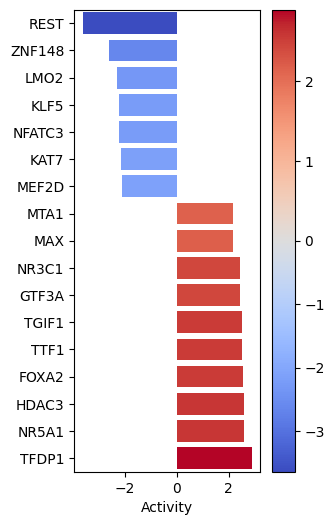

In [ ]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=17,
    vertical=True,
    figsize=(3, 6),
)

In [ ]:
# dc.plot_network(
#     net=collectri,
#     obs=mat,
#     act=tf_acts,
#     n_sources=['REST', 'ZNF148','LMO2', 'KLF5', 'FOXA2', 'HDAC3', 'NR5A1', 'TFDP1'],
#     n_targets=10,
#     node_size=50,
#     figsize=(8, 8),
#     c_pos_w='darkgreen',
#     c_neg_w='darkred',
#     vcenter=True,
#     t_cmap='summer'
# )

In [ ]:
# dc.plot_network(
#     net=collectri,
#     obs=mat,
#     act=tf_acts,
#     n_sources=['REST', 'ZNF148','LMO2','HDAC3', 'NR5A1', 'TFDP1'],
#     n_targets=15,
#     node_size=50,
#     figsize=(5, 5),
#     c_pos_w='darkgreen',
#     c_neg_w='darkred',
#     vcenter=True,
#     t_cmap='summer'
# )

We will also infer pathway activities with the same input matrix `mat` using the PROGENy model and Multivariate Linear Model (`mlm`) method.

In [ ]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

In [ ]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 2427 targets for 14 sources.


Androgen      EGFR  Estrogen  Hypoxia  JAK-STAT  \
treatment.vs.control    1.1775 -0.231863   -0.1081 -0.32723 -0.268256   

                          MAPK      NFkB      PI3K      TGFb      TNFa  \
treatment.vs.control -0.539392 -1.863223  1.160203  0.319153  1.564546   

                         Trail      VEGF       WNT       p53  
treatment.vs.control  0.372097  0.708939  0.598564  0.282063

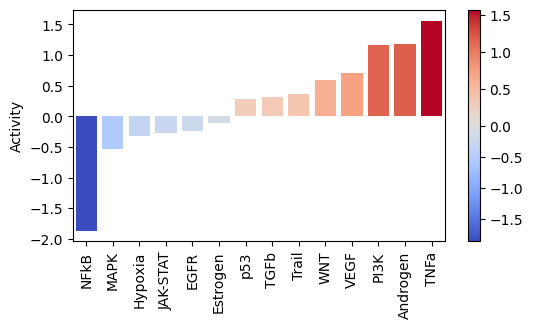

In [ ]:
dc.plot_barplot(
    pathway_acts,
    'treatment.vs.control',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

# Kim d77 annotated single-cell dataset - DEA with `scanpy.rank_genes_groups`

In [ ]:
kim_d77 = sc.read_h5ad("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/kim_d77_ann.h5ad.gz")
kim_d77

AnnData object with n_obs × n_vars = 7481 × 3000
    obs: 'Sample', 'condition', 'orig_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'condition_colors', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_symphony_R', 'X_pca_reference', 'X_umap'
    varm: 'PCs'

Preprocessing

In [ ]:
kim_d77.X = kim_d77.raw[:, kim_d77.var_names].X.copy()
sc.pp.normalize_total(kim_d77)
sc.pp.log1p(kim_d77)

DEA with scanpy

In [ ]:
# Perform DEA
sc.tl.rank_genes_groups(kim_d77, "condition", method="wilcoxon", use_raw=False)
# Get DEGs
kim_d77_degs = sc.get.rank_genes_groups_df(kim_d77, group="d77_fty_chronic")

In [ ]:
kim_d77_degs = kim_d77_degs.copy()
kim_d77_degs = kim_d77_degs.set_index("names")
kim_d77_degs

scores  logfoldchanges          pvals      pvals_adj
names                                                          
COL2A1  47.570698        5.832469   0.000000e+00   0.000000e+00
COL9A3  43.402985        6.282064   0.000000e+00   0.000000e+00
MATN3   38.707294        7.012120   0.000000e+00   0.000000e+00
COL9A1  38.610733        5.302363   0.000000e+00   0.000000e+00
CNMD    38.597767        7.358423   0.000000e+00   0.000000e+00
...           ...             ...            ...            ...
HES6   -29.196468       -1.297069  2.150084e-187  1.743312e-185
CLU    -29.212036       -1.309093  1.363870e-187  1.136558e-185
SOX4   -29.809460       -1.163442  2.945867e-195  2.678061e-193
MALAT1 -32.012543       -0.774202  7.296218e-225  9.120272e-223
CKB    -36.555206       -1.631613  1.473974e-292  6.317029e-290

[3000 rows x 4 columns]

In [ ]:
kim_d77_degs.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_sc_degs.csv")

# Kim d77 single-cell - ORA

Read in DEGs from `scanpy.tl.rank_genes_groups()` (with p-adjusted value < 0.05)

In [ ]:
kim_d77_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_sc_degs.csv", index_col=0)
kim_d77_degs

scores  logfoldchanges          pvals      pvals_adj
names                                                          
COL2A1  47.570698        5.832469   0.000000e+00   0.000000e+00
COL9A3  43.402985        6.282064   0.000000e+00   0.000000e+00
MATN3   38.707294        7.012120   0.000000e+00   0.000000e+00
COL9A1  38.610733        5.302363   0.000000e+00   0.000000e+00
CNMD    38.597767        7.358423   0.000000e+00   0.000000e+00
...           ...             ...            ...            ...
HES6   -29.196468       -1.297069  2.150084e-187  1.743312e-185
CLU    -29.212036       -1.309093  1.363870e-187  1.136558e-185
SOX4   -29.809460       -1.163442  2.945867e-195  2.678061e-193
MALAT1 -32.012543       -0.774202  7.296218e-225  9.120272e-223
CKB    -36.555206       -1.631612  1.473974e-292  6.317029e-290

[3000 rows x 4 columns]

Helper functions

In [ ]:
def filter_degs_sc(degs_df, padj_threshold=0.05, lfc_threshold=0.5, filter_cell_cycle_genes=True):
  """
  Given a scanpy rank_genes_groups results dataframe of DEGs, a maximum p-adj value (e.g. 0.05),
  and a positive log2FC threshold (e.g. 0.25), return a filtered dataframe.
  """
  if degs_df.empty:
    return degs_df
  # Filter DEGs by p-value and log fold change
  degs_df = degs_df[(degs_df['pvals_adj'] < padj_threshold) & (abs(degs_df['logfoldchanges']) > lfc_threshold)].copy()
  # Filter out cell cycle genes
  with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GO cell cycle genes.txt", "r") as f:
    cell_cycle_genes = f.read().strip().split(",")
  degs_df = degs_df[~degs_df.index.isin(cell_cycle_genes)].copy()
  # Filter out ribosomal and mitochondrial genes
  degs_df = degs_df[~degs_df.index.str.startswith(("RPS", "RPL", "MT-"))].copy()
  return degs_df

def get_up_down_degs(degs_df):
  """
  Given a filtered PyDESeq2 results dataframe of DEGs, return lists of upregulated
  and downregulated DEGs.
  """
  if degs_df.empty:
    return [], []
  gene_list = degs_df.index.tolist()
  degs_up = degs_df[degs_df['logfoldchanges'] > 0].index.tolist()
  degs_down = degs_df[degs_df['logfoldchanges'] < 0].index.tolist()
  return degs_up, degs_down

def run_ora(degs_up, degs_down, gene_set: str):
  # Run ORA with one gene set
  up = gp.enrichr(gene_list=degs_up, gene_sets=gene_set, organism="human", outdir=None)
  down = gp.enrichr(gene_list=degs_down, gene_sets=gene_set, organism="human", outdir=None)
  up_df, down_df = up.results, down.results
  return up_df, down_df

def filter_ora_results(ora_df, padj_threshold=0.05, min_genes=1):
  # Handle empty DataFrame
  if ora_df.empty:
    return ora_df
  # Apply thresholds
  ora_df = ora_df[
      (ora_df['Adjusted P-value'] < padj_threshold) &
      (ora_df["Overlap"].apply(lambda x: int(x.split("/")[0]) >= min_genes))
      ].copy()
  if ora_df.empty:
    return ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']]
  # Round values
  ora_df.loc[:, 'Adjusted P-value'] = ora_df['Adjusted P-value'].round(4).copy()
  ora_df.loc[:, 'Odds Ratio'] = ora_df['Odds Ratio'].round(1).copy()
  ora_df.loc[:, 'Combined Score'] = ora_df['Combined Score'].round().copy()
  # Sort and filter
  ora_df.sort_values('Combined Score', ascending=False, inplace=True)
  return ora_df

def display_ora_summary(ora_df):
  ora_df = ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']].copy()
  return ora_df

Filter DEGs with |LFC| > 1

In [ ]:
kim_d77_filtered = filter_degs_sc(kim_d77_degs, lfc_threshold=1)
kim_d77_filtered

scores  logfoldchanges          pvals      pvals_adj
names                                                          
COL2A1  47.570698        5.832469   0.000000e+00   0.000000e+00
COL9A3  43.402985        6.282064   0.000000e+00   0.000000e+00
MATN3   38.707294        7.012120   0.000000e+00   0.000000e+00
COL9A1  38.610733        5.302363   0.000000e+00   0.000000e+00
CNMD    38.597767        7.358423   0.000000e+00   0.000000e+00
...           ...             ...            ...            ...
MPC1   -28.582235       -1.342400  1.117223e-179  7.448154e-178
HES6   -29.196468       -1.297069  2.150084e-187  1.743312e-185
CLU    -29.212036       -1.309093  1.363870e-187  1.136558e-185
SOX4   -29.809460       -1.163442  2.945867e-195  2.678061e-193
CKB    -36.555206       -1.631612  1.473974e-292  6.317029e-290

[453 rows x 4 columns]

Separate into upregulated and downregulated genes

In [ ]:
kim_d77_up, kim_d77_down = get_up_down_degs(kim_d77_filtered)

In [ ]:
print(f"upregulated DEGS: {kim_d77_up}")
print(f"downregulated DEGS: {kim_d77_down}")

upregulated DEGS: ['COL2A1', 'COL9A3', 'MATN3', 'COL9A1', 'CNMD', 'COL11A1', 'SCRG1', 'HAPLN1', 'SNORC', 'COL11A2', 'COL9A2', 'GPC3', 'DLK1', 'EPYC', 'UCMA', 'ACAN', 'ITM2A', 'S100A1', 'FMOD', 'MATN4', 'PRELP', 'FIBIN', 'MIA', 'FRZB', 'IGFBP7', 'PLAC9', 'GREM1', 'LGALS3', 'POSTN', 'PMP22', 'C1QTNF3', 'COL27A1', 'SRPX', 'PTN', 'CSPG4', 'EMILIN1', 'MATN1', 'COL16A1', 'MMP2', 'CAPN6', 'BGN', 'COL1A2', 'CD9', 'ANGPTL7', 'COL14A1', 'CYR61', 'SOX6', 'S100A13', 'SERPINH1', 'SPARC', 'S100A10', 'COL3A1', 'BOC', 'THBS1', 'EMP3', 'S100B', 'SCIN', 'CREB3L2', 'PPIC', 'RFLNA', 'WWP2', 'KLF2', 'SCUBE2', 'CTHRC1', 'GDF5', 'AGTR2', 'FCGRT', 'PYGL', 'PAPSS2', 'FGFRL1', 'NID2', 'HSPG2', 'C9orf3', 'COMP', 'FBN2', 'OAF', 'IGF2-1', 'EDIL3', 'DCN', 'DHRS3', 'RGS10', 'TPM2', 'PIEZO2', 'ZNF385B', 'VCAN', 'RRBP1', 'MFAP4', 'CRISPLD1', 'NOG', 'LGALS1', 'CDC42EP5', 'FAM114A1', 'LPAR4', 'CRTAP', 'TRPS1', 'PITX1', 'ANXA5', 'CLEC18A', 'CSGALNACT1', 'MDFI', 'NFIX', 'ITGB5', 'ENPP1', 'XYLT1', 'FGFR3', 'S100A11', 'RHOD

Run ORA with GO

In [ ]:
kim_d77_up_go, kim_d77_down_go = run_ora(kim_d77_up, kim_d77_down, "GO_Biological_Process_2023")

Display ORA results for upregulated genes with minimum 5 genes per pathway

In [ ]:
kim_d77_up_go_filtered = filter_ora_results(kim_d77_up_go, min_genes=5)
display_ora_summary(kim_d77_up_go_filtered).head(10)

Term  Adjusted P-value  \
2           Collagen Fibril Organization (GO:0030199)            0.0000   
0      Extracellular Matrix Organization (GO:0030198)            0.0000   
1            Skeletal System Development (GO:0001501)            0.0000   
3   Extracellular Structure Organization (GO:0043062)            0.0000   
4   External Encapsulating Structure Organization ...            0.0000   
7   Regulation Of Chondrocyte Differentiation (GO:...            0.0000   
5                  Cartilage Development (GO:0051216)            0.0000   
9        Endodermal Cell Differentiation (GO:0035987)            0.0000   
10         Connective Tissue Development (GO:0061448)            0.0000   
12                    Endoderm Formation (GO:0001706)            0.0003   

    Odds Ratio  Combined Score Overlap  \
2         44.2          1685.0   14/42   
0         21.3          1375.0  32/176   
1         20.7          1128.0  27/149   
3         19.1           720.0  19/109   
4         18.8           709.0  19/110   
7         33.4           609.0    7/25   
5         23.4           577.0   11/52   
9         25.0           415.0    7/31   
10        19.4           292.0    7/38   
12        17.7           224.0    6/35   

                                                Genes  
2   CRTAP;COL27A1;COL14A1;LUM;COL11A1;COL11A2;COL1...  
0   COL16A1;COL14A1;COL11A1;COL12A1;COL11A2;CAPG;N...  
1   UCMA;NPR3;COL11A2;XYLT1;PRELP;COMP;CLEC3A;EXTL...  
3   POSTN;COL16A1;MIA;COL14A1;MMP2;COL11A1;MMP14;C...  
4   POSTN;COL16A1;MIA;COL14A1;MMP2;COL11A1;MMP14;C...  
7              GREM1;SCIN;TRPS1;SNAI2;SOX6;GDF5;LOXL2  
5   SLC26A2;COL2A1;SNORC;EPYC;CREB3L2;COL11A2;OGN;...  
9         MMP14;ITGB5;COL11A1;MMP2;COL12A1;FN1;COL8A1  
10      COL2A1;SNORC;COL11A2;CREB3L2;CHI3L1;SOX8;SOX6  
12                MMP14;ITGB5;MMP2;COL12A1;FN1;COL8A1

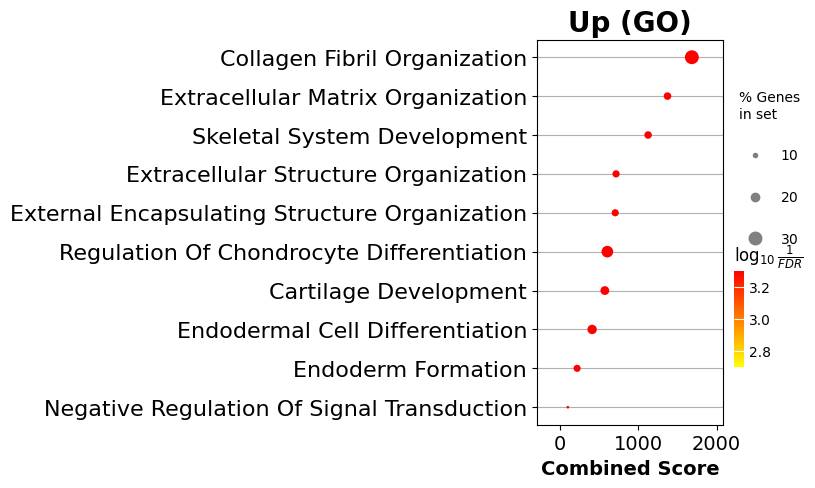

In [ ]:
# trim (go:...)
kim_d77_up_go_filtered.Term = kim_d77_up_go_filtered.Term.str.split(" \(GO").str[0]
# dotplot
gp.dotplot(kim_d77_up_go_filtered, figsize=(3,5), title="Up (GO)", cmap = plt.cm.autumn_r)
plt.show()

In [ ]:
kim_d77_up_go_filtered.shape[0]

40

Save

In [ ]:
kim_d77_up_go_filtered.to_excel('/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_ORA_upregulated_genes_GO.xlsx', index=False)

Display ORA results for downregulated genes with minimum 5 genes per pathway

In [ ]:
kim_d77_down_go_filtered = filter_ora_results(kim_d77_down_go, min_genes=5)
display_ora_summary(kim_d77_down_go_filtered)

Term  Adjusted P-value  \
0   Synaptic Transmission, Glutamatergic (GO:0035249)            0.0070   
2   Regulation Of Synaptic Transmission, Glutamate...            0.0111   
1                       Synapse Assembly (GO:0007416)            0.0070   
4                 Cell Junction Assembly (GO:0034329)            0.0186   
10  Positive Regulation Of Cell Junction Assembly ...            0.0494   
9   Modulation Of Chemical Synaptic Transmission (...            0.0463   
3     Central Nervous System Development (GO:0007417)            0.0186   
13        Circulatory System Development (GO:0072359)            0.0494   
14  Negative Regulation Of Cell Motility (GO:2000146)            0.0494   
8            Organic Substance Transport (GO:0071702)            0.0463   
6         Chemical Synaptic Transmission (GO:0007268)            0.0340   
12  Cell-Cell Adhesion Via Plasma-Membrane Adhesio...            0.0494   

    Odds Ratio  Combined Score Overlap  \
0         21.3           247.0    5/27   
2         11.5           121.0    6/55   
1         10.3           117.0    7/71   
4          7.5            71.0    7/95   
10         8.3            63.0    5/61   
9          5.7            45.0   7/123   
3          4.2            41.0  12/283   
13         5.3            39.0   7/132   
14         5.2            39.0   7/133   
8          4.4            35.0   9/201   
6          4.0            34.0  11/273   
12         4.6            34.0   8/172   

                                                Genes  
0                      GRIN2A;GRID2;GRIK3;CDHR3;GRIK1  
2                  GRIN2A;CDH2;SYT1;NRXN1;GRIK3;GRIK1  
1        GABRB2;GABRA1;GRID2;CDH2;FLRT3;NRXN1;SLITRK6  
4           CLDN5;CDH2;FLRT3;NRXN1;CDHR3;SLITRK6;CDH7  
10                    CLDN5;GRID2;CLDN3;NRXN1;SLITRK6  
9             GRID2;CDH2;SYT1;GRIK3;GRIK1;NPTX2;CPLX3  
3   GRIN2A;SHH;ZFHX3;RTN1;CDH2;NKX2-1;FOXJ1;GRIK1;...  
13                 CRB2;SHH;PDLIM3;TH;HEY1;FLRT3;SOX4  
14           BST2;CLDN5;SHH;TMEFF2;CLDN3;NKX2-1;SLIT2  
8   RYR1;CUBN;CACNA2D1;TXNIP;LRP2;ABCA13;CLU;PLTP;...  
6   GABRA1;GABRB2;GRIN2A;GRID2;TH;SYT1;NRXN1;GRIK3...  
12       CRB2;CLDN5;GRID2;CDH2;FLRT3;CLDN7;CDHR3;CDH7

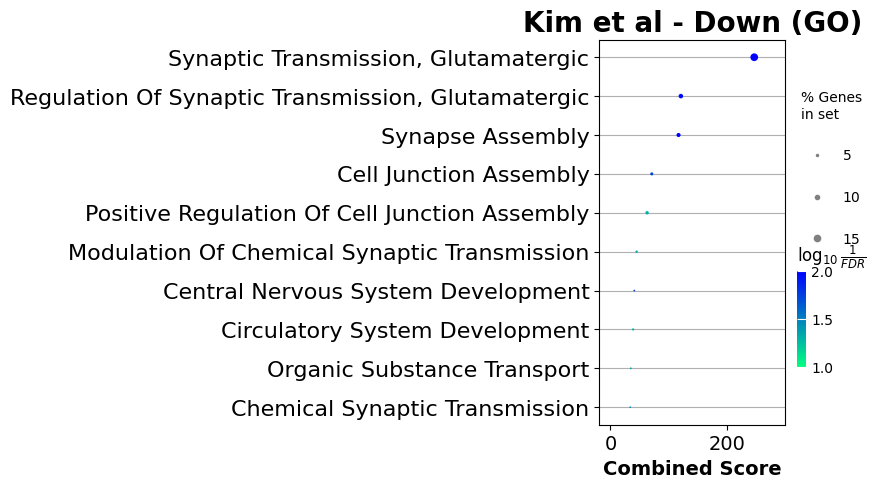

In [ ]:
# trim (go:...)
kim_d77_down_go_filtered.Term = kim_d77_down_go_filtered.Term.str.split(" \(GO").str[0]
gp.dotplot(kim_d77_down_go_filtered, figsize=(3,5), title="Kim et al - Down (GO)", cmap = plt.cm.winter_r, size=5)
plt.show()

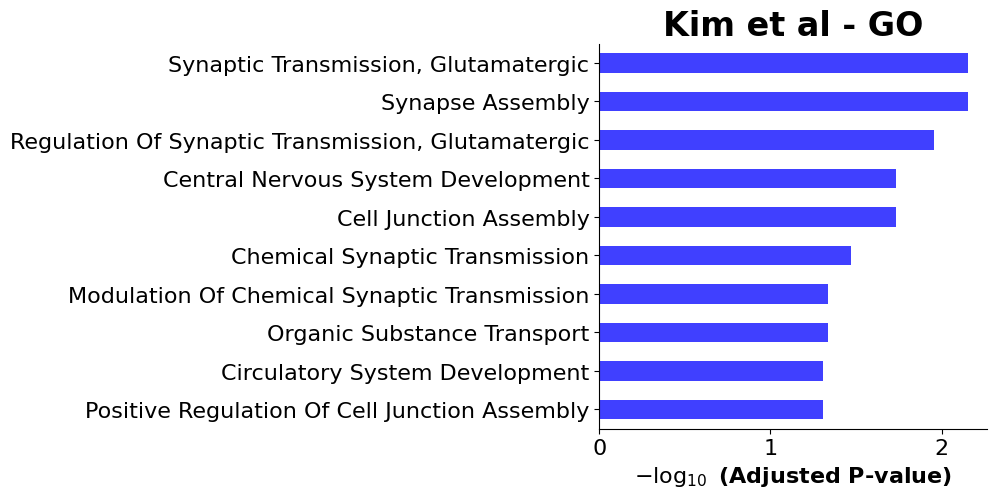

In [ ]:
ax = gp.barplot(kim_d77_down_go_filtered, figsize=(5,5),
                title ="Kim et al - GO",
                color = 'b')

In [ ]:
kim_d77_down_go_filtered.to_excel('/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_ORA_downregulated_genes_GO.xlsx', index=False)

Display ORA results for both up- and downregulated genes

In [ ]:
# Concatenate for plotting
kim_d77_up_go_filtered['UP_DW'] = "UP"
kim_d77_down_go_filtered['UP_DW'] = "DOWN"
kim_d77_go = pd.concat([kim_d77_up_go_filtered.head(11), kim_d77_down_go_filtered.head(11)])

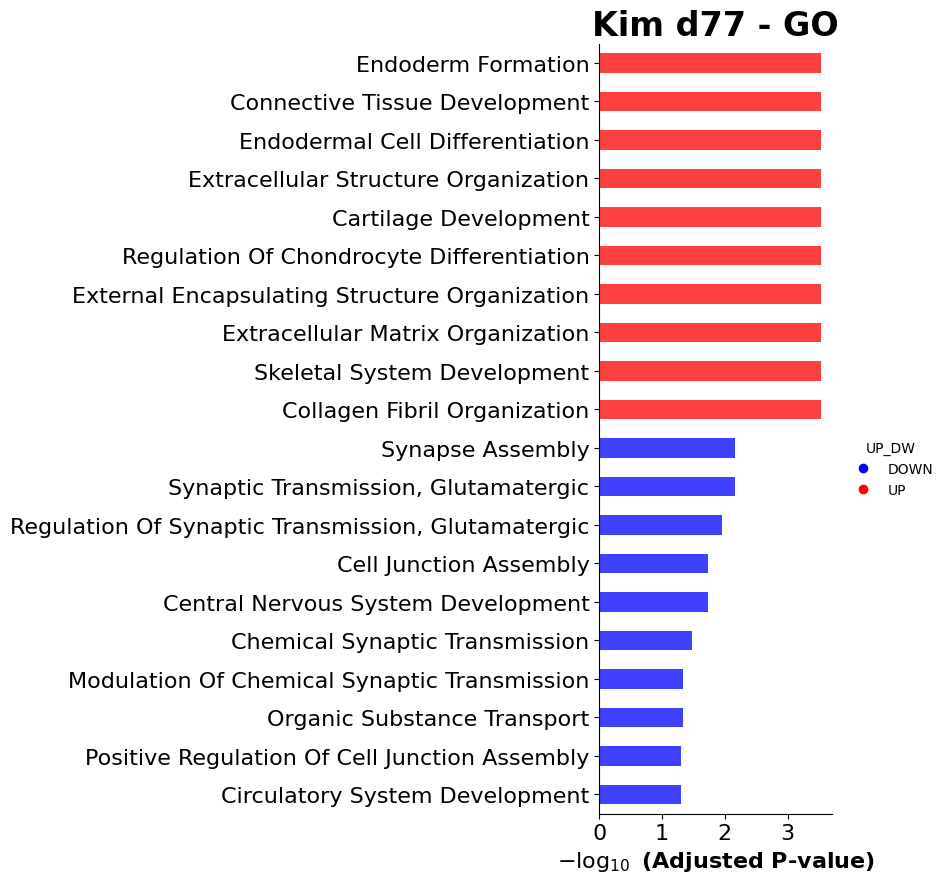

In [ ]:
# display multi-datasets
ax = gp.barplot(kim_d77_go, figsize=(3,10),
                group ='UP_DW',
                title ="Kim d77 - GO",
                color = ['b','r'])

Run ORA with MSig database

In [ ]:
bkim_d77_up_msig, kim_d77_down_msig = run_ora(kim_d77_up, kim_d77_down, "MSigDB_Hallmark_2020")

In [ ]:
kim_d77_up_msig_filtered = filter_ora_results(kim_d77_up_msig, min_genes=5)
display_ora_summary(kim_d77_up_msig_filtered)

Term  Adjusted P-value  Odds Ratio  \
0   Epithelial Mesenchymal Transition            0.0000        24.9   
1                         Coagulation            0.0000         8.3   
2                             Hypoxia            0.0001         5.6   
3                      UV Response Dn            0.0006         5.7   
4                IL-2/STAT5 Signaling            0.0010         4.6   
5              Estrogen Response Late            0.0010         4.5   
8             Cholesterol Homeostasis            0.0085         6.2   
6                          Myogenesis            0.0038         4.0   
10                          Apoptosis            0.0117         3.9   
9                          Glycolysis            0.0111         3.6   
11                         Complement            0.0341         3.1   

    Combined Score Overlap                                              Genes  
0           2115.0  40/200  FBN2;SPARC;COL16A1;ITGB5;COL11A1;COL12A1;CAPG;...  
1            134.0  12/138  COMP;MMP14;SPARC;S100A1;CTSK;MMP2;MAFF;S100A13...  
2             68.0  12/200  CA12;SRPX;CAVIN1;LOX;CAVIN3;CAV1;MAFF;BGN;GPC3...  
3             56.0   9/144  COL3A1;COL1A2;SIPA1L1;CAV1;COL11A1;GCNT1;PMP22...  
4             41.0  10/199  ITIH5;AHNAK;S100A1;MAFF;NFKBIZ;EMP1;ENPP1;CAPG...  
5             40.0  10/200  CA12;SCUBE2;SLC26A2;CXCL12;CAV1;NMU;CD9;EMP2;F...  
8             39.0    5/74                      LGALS3;ANXA5;GPX8;CD9;S100A11  
6             30.0   9/200  COL3A1;SPARC;ITGB5;TPM2;FST;TNNT3;SSPN;COL6A3;...  
10            22.0   7/161                  LGALS3;LUM;CAV1;MMP2;BGN;EMP1;DCN  
9             21.0   8/200          VCAN;DEPDC1;GPC3;KDELR3;PYGL;LHX9;HK2;DCN  
11            14.0   7/200           LGALS3;MMP14;ANXA5;MAFF;S100A13;FN1;CTSH

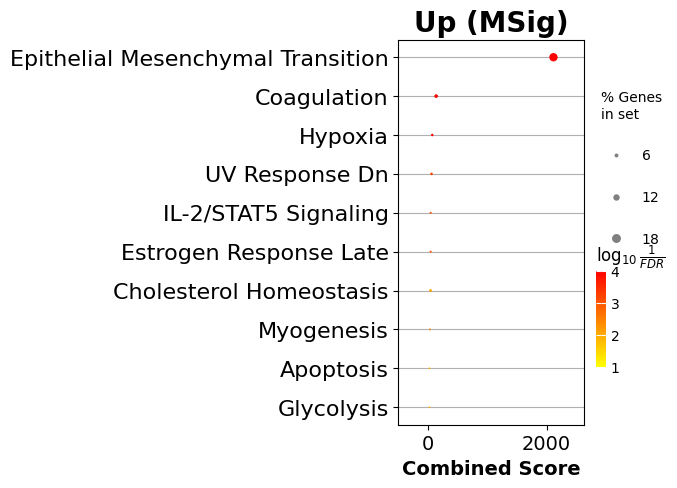

In [ ]:
gp.dotplot(kim_d77_up_msig_filtered, figsize=(3,5), title="Up (MSig)", cmap = plt.cm.autumn_r)
plt.show()

In [ ]:
kim_d77_up_msig_filtered.to_excel('/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_ORA_upregulated_genes_MSig.xlsx', index=False)

In [ ]:
kim_d77_down_msig_filtered = filter_ora_results(kim_d77_down_msig, min_genes=5)
display_ora_summary(kim_d77_down_msig_filtered)

Term  Adjusted P-value  Odds Ratio  Combined Score Overlap  \
1  KRAS Signaling Up             0.029         3.9            25.0   8/200   

                                             Genes  
1  AKAP12;TPH1;TMEM176B;RGS16;VWA5A;SPP1;SCG5;PLAT

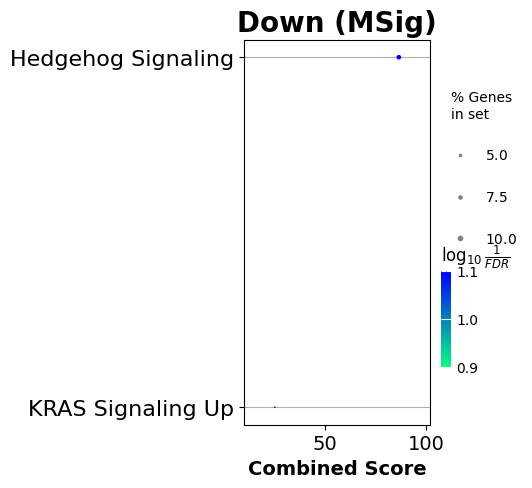

In [ ]:
gp.dotplot(kim_d77_down_msig, figsize=(3,5), title="Down (MSig)", cmap = plt.cm.winter_r, size=5)
plt.show()

In [ ]:
kim_d77_down_msig_filtered.to_excel('/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_ORA_downregulated_genes_MSig.xlsx', index=False)

# Comparing Kim et al and Ho et al DEGs

Read in Kim et al DEGs from single-cell DEA

In [ ]:
kim_degs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/kim_d77_sc_degs.csv", index_col=0)
kim_degs_df

scores  logfoldchanges          pvals      pvals_adj
names                                                          
COL2A1  47.570698        5.832469   0.000000e+00   0.000000e+00
COL9A3  43.402985        6.282064   0.000000e+00   0.000000e+00
MATN3   38.707294        7.012120   0.000000e+00   0.000000e+00
COL9A1  38.610733        5.302363   0.000000e+00   0.000000e+00
CNMD    38.597767        7.358423   0.000000e+00   0.000000e+00
...           ...             ...            ...            ...
HES6   -29.196468       -1.297069  2.150084e-187  1.743312e-185
CLU    -29.212036       -1.309093  1.363870e-187  1.136558e-185
SOX4   -29.809460       -1.163442  2.945867e-195  2.678061e-193
MALAT1 -32.012543       -0.774202  7.296218e-225  9.120272e-223
CKB    -36.555206       -1.631612  1.473974e-292  6.317029e-290

[3000 rows x 4 columns]

In [ ]:
kim_degs_df = kim_degs_df[(kim_degs_df["pvals_adj"] < 0.05) & (abs(kim_degs_df["logfoldchanges"]) > 1)].copy()
kim_degs_df

scores  logfoldchanges          pvals      pvals_adj
names                                                          
COL2A1  47.570698        5.832469   0.000000e+00   0.000000e+00
COL9A3  43.402985        6.282064   0.000000e+00   0.000000e+00
MATN3   38.707294        7.012120   0.000000e+00   0.000000e+00
COL9A1  38.610733        5.302363   0.000000e+00   0.000000e+00
CNMD    38.597767        7.358423   0.000000e+00   0.000000e+00
...           ...             ...            ...            ...
MPC1   -28.582235       -1.342400  1.117223e-179  7.448154e-178
HES6   -29.196468       -1.297069  2.150084e-187  1.743312e-185
CLU    -29.212036       -1.309093  1.363870e-187  1.136558e-185
SOX4   -29.809460       -1.163442  2.945867e-195  2.678061e-193
CKB    -36.555206       -1.631612  1.473974e-292  6.317029e-290

[540 rows x 4 columns]

In [ ]:
kim_degs = kim_degs_df.index.tolist()
print(kim_degs[:10])

['COL2A1', 'COL9A3', 'MATN3', 'COL9A1', 'CNMD', 'COL11A1', 'SCRG1', 'HAPLN1', 'SNORC', 'COL11A2']


Read in Ho et al DEGs

In [ ]:
ho_degs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_unfiltered.csv", index_col=0)

In [ ]:
ho_degs_df = ho_degs_df[(abs(ho_degs_df["log2FoldChange"]) > 0.5) & (ho_degs_df["padj"] < 0.1)].copy()
ho_degs_df

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                 
CLDN19       115.088716        1.883641  0.556975  3.381911  7.198341e-04   
CYP4X1        37.186848       -1.481800  0.295444 -5.015500  5.289569e-07   
BARHL2        33.092894       -1.555892  0.413985 -3.758333  1.710493e-04   
GCLM         223.829100        0.738659  0.209349  3.528363  4.181376e-04   
SFT2D2        38.484464        0.751285  0.209638  3.583731  3.387209e-04   
...                 ...             ...       ...       ...           ...   
FAM155B      371.276361       -0.512368  0.117346 -4.366304  1.263666e-05   
DACH2         41.327722       -1.367060  0.280072 -4.881093  1.054997e-06   
IRS4          66.860703        1.717042  0.497735  3.449708  5.611930e-04   
TENM1        177.531048       -1.153973  0.280068 -4.120334  3.783242e-05   
MOSPD1       372.582582        0.699189  0.178129  3.925193  8.666028e-05   

                 padj  
gene_symbol            
CLDN19       0.090431  
CYP4X1       0.000723  
BARHL2       0.039457  
GCLM         0.067977  
SFT2D2       0.059345  
...               ...  
FAM155B      0.007190  
DACH2        0.001126  
IRS4         0.079170  
TENM1        0.016145  
MOSPD1       0.024655  

[92 rows x 6 columns]

In [ ]:
ho_degs = ho_degs_df.index.tolist()
print(ho_degs[:10])

['CLDN19', 'CYP4X1', 'BARHL2', 'GCLM', 'SFT2D2', 'F5', 'KCNH1', 'TMEM72', 'PRAP1', 'CDKN1C']


In [ ]:
common_degs = set(kim_degs) & set(ho_degs)
common_degs = list(common_degs)
print(common_degs[:10])
print(len(common_degs))

['COL2A1', 'BARHL2']
2


In [ ]:
kim_degs_df.loc["BARHL2"]

scores           -1.031869e+01
logfoldchanges   -1.494147e+00
pvals             5.800902e-25
pvals_adj         3.734486e-24
Name: BARHL2, dtype: float64

In [ ]:
ho_degs_df.loc["BARHL2"]

baseMean          33.092894
log2FoldChange    -1.555892
lfcSE              0.413985
stat              -3.758333
pvalue             0.000171
padj               0.039457
Name: BARHL2, dtype: float64

In [ ]:
kim_degs_df.loc["COL2A1"]

scores            47.570698
logfoldchanges     5.832469
pvals              0.000000
pvals_adj          0.000000
Name: COL2A1, dtype: float64

In [ ]:
ho_degs_df.loc["COL2A1"]

baseMean          350.056042
log2FoldChange      0.844807
lfcSE               0.241349
stat                3.500351
pvalue              0.000465
padj                0.069811
Name: COL2A1, dtype: float64